<h1>Projet AirFrance - Placement de Passagers</h1>
<h2> CentraleSupélec - 2ème Année - 2021</h2>

<h3> Thomas Bouquet, Caio De Prospero Iglesias, Quentin Guilhot, Thomas Melkior, Tony Wu</h3>

On s'intéresse ici à un problème d'optimisation visant à placer des passagers dans un avion de ligne de telle sorte à maximiser la satisfaction client tout en respectant un lot de consignes de sécurité obligatoires. Un second objectif est bien évidemment de résoudre le problème en un temps minimum.

# Importation des modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from gurobipy import *

import os
from typing import Generator
import pandas as pd

from random import randint
import json
import math

from datetime import datetime
import timeit
import logging

# Les avions

## Modèles formels

Pour ce problème, on considère principalement deux avions <strong>Airbus A320</strong> et <strong>Airbus A321</strong> de la compagnie <strong>Air France</strong> dont l'organisation intérieure est présentée sur l'image suivante :
<br>
<img src="cabineA320AF.jpg">
<p style="text-align: center;"><strong>Plan de l'Airbus A320</strong></p>
<br>

<img src="cabineA321AF.jpg">
<p style="text-align: center;"><strong>Plan de l'Airbus A321</strong></p>
<br>

## Représentation informatique

<div style = "text-align: justify,">
Afin de rendre la modélisation informatique plus efficace, il convient de légèrement simplifier la disposition géométrique de la cabine afin de la rendre plus "régulière". Pour cela, on considère les hypothèses simplificatrices suivantes :
<ul>
    <li> L'espace entre deux rangées successives est uniforme dans toute la cabine;
    <li> L'allée centrale est de même largeur qu'une colonne de sièges;
    <li> L'espace entre deux sièges de classe Business est lui aussi de même largeur qu'un siège.    
</ul>
Une autre hypothèse que nous allons effectuer est qu'il n'y a pas de surbooking, c'est-à-dire que :
<ul>
    <li> Il y a de la place pour tous les passagers dans l'avion;
    <li> Il n'y a pas plus de passagers en classe Business que de place Business disponibles dans la cabine. 
</ul>
Cela permet donc d'avoir une représentation géométrique de l'intérieur de la cabine plus simple. Il suffit donc juste de considérer que certains sièges sont des sièges vides, dans le sens où personne ne pourra s'asseoir dessus, étant donné qu'en réalité, il s'agit d'espaces vides.
<br>
<br>
Il est possible de changer le jour de l'instance et de sélectionner le modèle de l'avion dans la cellule ci-dessous.
</div>

In [2]:
AVION = "A321"
#AVION = "A321"  

# choix de la date
date = '15Nov' # Pour le 10 novembre, bien choisir un A321

# Les passagers

## Définition informatique des objets

Afin de simplifier l'utilisation des différentes données relatives aux passagers (âge, sexe, poids, classe, temps de correspondance, ...), nous avons fait le choix d'implémenter une classe objet Python pour les modéliser informatiquement. Cela permettra un appel à ces données plus aisé et commode. La classe ```Passager``` est définie ci-dessous.

In [3]:
# Initialisation de compteurs

numPassager = 0
numFemme = 0
numHomme = 0
numEnfant = 0
numWHCR = 0

In [4]:
class Passager:
    
    """
    Une classe représentant un passager et toutes les données qui lui sont associées. 
    """
    
    def __init__(self, idx, id_passager, categorie, classe, transit_time=0):
        
        """
        Constructeur pour la classe Passager.
        
        Args:
            idx (int): Indice du groupe dans le fichier Excel
            categorie (Categories): Catégorie du passager (Femme, Homme, Enfant, Fauteil Roulant)
            classe (Classes): Lettre donnant la classe du passager
            transit_time (string, optional): String au format %H:%M:%S donnat le
                temps de transit pour le passager. Defaults to 0.
        """
        
        self.idx = idx
        self.id_passager = id_passager
        self.categorie = categorie
        self.classe = classe
        self.transit_time = transit_time
        self.poids()
    
    def __str__(self):
        return f'Passager # {self.id_passager}, catégorie {self.categorie} du groupe #{self.idx}, classe {self.classe} et temps de correspondance de {self.transit_time}'
    
    def __repr__(self):
        return f'passager # {self.id_passager} du groupe #{self.idx}'          
    
    def poids(self):
        """
        Définit le poids du passager selon sa catégorie.
        """
        
        global numFemme, numHomme, numWHCR, numEnfant
        
        # Pour chaque passager, on modifie très légèrement le poids pour "briser" la symétrie
        
        if self.categorie == "femmes":
            self.poids = 65 + numFemme / 100
            numFemme += 1
        elif self.categorie == "hommes":
            self.poids = 80 + numHomme / 100
            numHomme += 1
        elif self.categorie == "WHCR":
            self.poids = 70 + numWHCR / 100
            numWHCR += 1
        else:
            self.poids = 35 + numEnfant / 100
            numEnfant += 1

Dans cette même logique, on définit une classe ```Groupe``` pour décrire les groupes de passagers voyageant ensemble.

In [5]:
class Groupe:
    
    """
    Une classe représentant un groupe de passagers ayant réservé leur places d'avion ensemble. 
    Un groupe correspond donc à une ligne dans le fichier Excel de départ.
    """

    def __init__(self, idx, nb_femmes, nb_hommes, nb_enfants, nb_WCHR, classe, transit_time=0):
        
        """
        Constructeur pour la classe Groupe.
        
        Args:
            idx (int): Indice du groupe dans le fichier Excel
            nb_femmes (int): Nombre de femmes dans le groupe
            nb_hommes (int): Nombre d'hommes dans le groupe
            nb_enfants (int): Nombre d'enfants dans le groupe
            nb_WCHR (int): Nombre de personnes handicapés dans le groupe
            classe (Classes): Lettre donnant la classe du groupe
            transit_time (string, optional): String au format %H:%M:%S donnat le
                temps de transit pour le groupe. Defaults to 0.
        """
        
        self.idx = idx
        self.composition = {
            'femmes': nb_femmes,
            'hommes': nb_hommes,
            'enfants': nb_enfants,
            'WHCR': nb_WCHR
        }
        self.classe = classe
        self.transit_time = transit_time

        self.list_passagers = []
        global numPassager

        for categorie in self.composition.keys():
            for nbParCategorie in range(self.composition[categorie]):
                self.list_passagers.append(Passager(
                    self.idx,
                    numPassager,
                    categorie,
                    self.classe,
                    self.transit_time))
                numPassager += 1   

        return

    def __str__(self):
        return f'Groupe #{self.idx} avec {self.get_nombre_passagers()} passager(s), classe {self.classe} et temps de correspondance de {self.transit_time}'

    def __repr__(self):
        return f'groupe #{self.idx}'
    
    def iter_passagers(self):
        """Générateur pour la liste des passagers dans le groupe.
        Yields:
            Passager: instance de la classe Passager
        """
        for passager in self.list_passagers:
            yield passager

    def est_seul(self):
        """Renvoie True si le groupe contient un seul
        passager et False sinon.
        """
        return len(self.list_passagers) == 1
    
    def get_nombre_passagers(self):
        """Renvoie le nombre de passagers dans le groupe considéré.
        """
        return len(self.list_passagers)

    def comprend_enfants(self):
        """Renvoie True si le groupe contient au moins un enfant
        en son sein et False sinon.
        """
        return any([passager.categorie == 'enfants' for passager in self.list_passagers])      

##  Récupération de la liste des passagers à partir du jeu de données réelles au format ```.xlsx```

On définit ci-dessous des fonctions Python permettant d'extraire les données des différents vols.

In [6]:
def read_and_preprocess(date):
    df = pd.read_csv(get_filepath(date))

    # Conversion en TimeStamp
    df['TransitTime'] = pd.to_datetime(df['TransitTime']).dt.time

    return df

def get_list_passagers(df):
    list_groupes = {}

    for idx, row in df.iterrows():

        list_groupes[idx] = Groupe(
            idx=idx,
            nb_femmes=row['Femmes'],
            nb_hommes=row['Hommes'],
            nb_enfants=row['Enfants'],
            nb_WCHR=row['WCHR'],
            classe=row['Classe'],
            transit_time=string_to_min(str(row['TransitTime']))
        )
    
    return list_groupes

def get_filepath(date, data_source='data'):
    """Renvoie le filepath d'un fichier donné 
    Args:
        date (string): string contenant la date sous
            le format {jour}{Mois abbrégé}
            -> exemple : 7Nov
    Returns:
        string
    """
    return os.path.join(data_source, f'data_seating_{date}.csv')

On commence par afficher sous forme de tableau les données du jour à des fins visuelles. .

In [7]:
df = read_and_preprocess(date)
df # Affichage

Femmes  Hommes  Enfants  WCHR Classe TransitTime
0        1       0       10     0      Y    00:00:00
1        0       0        5     0      Y    00:00:00
2        0       1        2     0      Y    00:00:00
3        0       0        1     0      Y    00:00:00
4        0       0        1     0      Y    00:00:00
5        0       1        2     0      Y    00:00:00
6        0       1        2     0      Y    01:00:00
7        0       0       10     0      Y    00:00:00
8        0       0        2     0      Y    00:00:00
9        0       2        0     0      Y    01:00:00
10       0       0        1     0      Y    00:00:00
11       0       1        0     0      Y    00:00:00
12       0       0        1     0      Y    00:00:00
13       0       0        1     0      Y    00:00:00
14       0       0        1     0      Y    01:00:00
15       0       0        1     0      Y    00:00:00
16       1       0        1     0      Y    00:00:00
17       1       0        0     0      Y    00:00:00
18       0       0        1     0      Y    00:00:00
19       0       0        1     0      Y    00:00:00
20       2       0       15     0      Y    01:25:00
21       2       0       15     0      Y    00:00:00
22       0       0        1     0      Y    01:00:00
23       0       0        1     0      Y    01:25:00
24       1       0        0     0      Y    00:00:00
25       1       1        0     0      Y    00:00:00
26       0       1        0     0      Y    00:00:00
27       0       0        1     0      Y    00:00:00
28       0       0        1     0      Y    00:00:00
29       0       1        0     0      Y    00:00:00
30       0       0        2     0      Y    01:25:00
31       0       0        2     0      Y    00:00:00
32       0       0        1     0      Y    01:25:00
33       0       0        1     0      Y    00:00:00
34       0       0        2     0      Y    01:00:00
35       0       0        2     0      Y    00:00:00
36       0       0        2     0      Y    00:00:00
37       1       0        0     0      Y    01:25:00
38       1       0        0     0      Y    00:00:00
39       0       0        2     0      Y    00:00:00
40       0       0        2     0      Y    01:25:00
41       0       0        1     0      Y    00:00:00
42       0       2        0     0      Y    00:00:00
43       0       0        1     0      Y    00:00:00
44       0       0        1     0      Y    00:00:00
45       0       0        1     0      Y    00:00:00
46       0       0        1     0      Y    00:00:00
47       0       0        1     0      Y    00:00:00
48       0       1        0     0      Y    00:00:00
49       1       1        2     0      Y    00:00:00
50       1       1        2     0      Y    00:00:00
51       1       0        0     0      Y    00:00:00
52       0       0        2     0      Y    01:00:00
53       0       0        1     0      Y    00:00:00
54       0       0        1     0      Y    01:25:00
55       0       0        1     0      Y    00:00:00

In [8]:
def string_to_min(date):
    
    """
    Fonction qui transforme une heure au format HH:MM:SS 
    en l'entier correspondant au nombre de minutes de cette dernière.
    """
    
    hms = date.split(":")
    if date == "00:00:00":
        return float('inf')
    else:
        return int(60*int(hms[0]) + int(hms[1]) + int(hms[2])*50/3)

Ensuite, on récupère la liste des passagers numériquement afin de l'utiliser dans notre code Python :

In [9]:
# Liste des groupes
listeGroupes = get_list_passagers(df)

# Liste des passagers, récupérée via la liste des groupes
listePassagers = []

for groupe in listeGroupes.keys():
    listePassagers += listeGroupes[groupe].list_passagers  
 
 # Réinitialisation des compteurs

numPassager = 0  
numFemme = 0
numHomme = 0
numEnfant = 0
numWHCR = 0

Ceci nous permet de connaître exactement le nombre de passagers dans l'avion :

In [10]:
nombrePassagers = len(listePassagers)
print("Il y a {} passagers dans l'avion.".format(nombrePassagers))

Il y a 136 passagers dans l'avion.


## Ensemble des groupes avec strictement plus d'un passager

Comme nous le verrons plus tard, il nous est fondamental de distinguer les groupes de plus d'un passager des autres. Nous les identifions avec le code ci-dessous.

In [11]:
liste_groupes_sup1 = {}

for groupe in listeGroupes.keys():
    if listeGroupes[groupe].get_nombre_passagers() > 1:
        liste_groupes_sup1[groupe] = listeGroupes[groupe]
        
print("Il y a {} groupes de plus d'un passagers dans l'avion. Il s'agit des groupes {}.".format(len(liste_groupes_sup1.keys()),list(liste_groupes_sup1.keys())))      

Il y a 23 groupes de plus d'un passagers dans l'avion. Il s'agit des groupes [0, 1, 2, 5, 6, 7, 8, 9, 16, 20, 21, 25, 30, 31, 34, 35, 36, 39, 40, 42, 49, 50, 52].


# Création de la cabine de l'avion

## Importation de la cabine à partir d'un fichier ```.json```

In [12]:
nb_business = 0
for passager in listePassagers:
    if passager.classe == "J":
        nb_business += 1
        
if nb_business == 0:
    extension = "_nb"
else:
    extension = ""   

In [13]:
# Chargement de l'avion à partir d'un fichier JSON
with open('./' + AVION + extension + '.json') as f:
    preprocess = json.load(f)

In [14]:
# Adaptation en dictionnaire 
avion = {
    'x_max': preprocess['x_max'],
    'y_max': preprocess['y_max'],
    'exit': preprocess['exit'],
    'hallway': preprocess['hallway'],
    'barycentre': preprocess['barycentre'],
    'background': preprocess['background'],
    'seats': {
        'real': [],
        'fictive': [],
        'business': [],
        'exit': [],
        'eco': []        
    }
}

for seat_category in preprocess['seats'].keys():
    for couple in preprocess['seats'][seat_category]:
        x,y = couple[0], couple[1]
        avion['seats'][seat_category].append((x,y))        

## Affichage de la cabine

**Avec MatPlotLib**

C:\Users\33695\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.


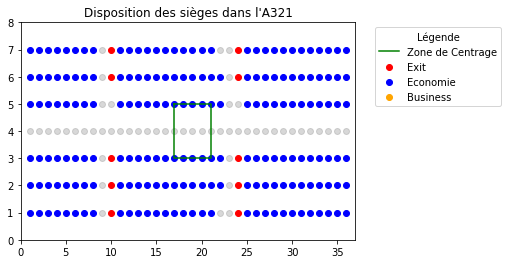

In [15]:
plt.scatter(1000,1000,color="red",label="Exit") 
plt.scatter(1000,1000,color="blue",label="Economie") 
plt.scatter(1000,1000,color="orange",label="Business") 

for x in range(1,avion['x_max']+1):
    for y in range(1,avion['y_max']+1):
        if (x,y) in avion['seats']['fictive']:
            plt.scatter(x,y,color="grey",alpha=0.3)
        elif (x,y) in avion['seats']['business']:
            plt.scatter(x,y,color="orange")
        elif (x,y) in avion['seats']['exit']:
            plt.scatter(x,y,color="red")
        else:
            plt.scatter(x,y,color="blue")
            
plt.plot([avion['barycentre'][0],avion['barycentre'][1],avion['barycentre'][1],avion['barycentre'][0],avion['barycentre'][0]],
         [avion['barycentre'][3],avion['barycentre'][3],avion['barycentre'][2],avion['barycentre'][2],avion['barycentre'][3]],
         color='green',
         label="Zone de Centrage")            
            
plt.axis([0,avion['x_max']+1,0,8],'equal')
plt.title("Disposition des sièges dans l'"+AVION)
plt.legend(bbox_to_anchor=(1.45,1),title="Légende")
plt.show()            

**Avec Plotly**

In [16]:
def coordToSiege(x,y):
    gapRangee = 0
    
    if AVION == "A320":
        
        if x > 12:
            gapRangee = 1
            
    elif AVION == "A321":
        
        if x >= 10 and x <= 13:
            gapRangee = -1
        elif x >= 24:
            gapRangee = -1
        
    lettre = ""
    if y == 1:
        lettre = "A"
    elif y == 2:
        lettre = "B"
    elif y == 3:
        lettre = "C"
    elif y == 5:
        lettre = "D"
    elif y == 6:
        lettre = "E"
    elif y == 7:
        lettre = "F" 
    return str(x+gapRangee)+lettre 

def get_classe(x, y):
    
    if AVION == "A320":
        if y == 4 or (x==1 and y in [4, 5, 6, 7]):
            return 'Siège vide'

        elif 1 <= x <= 9 and 1 <= y <= 7:
            return 'Business'

        elif x in [11, 12] and y in [1, 2, 3, 5, 6, 7]:
            return 'Issue de secours'

        else:
            return 'Economie'
        
    elif AVION == "A321":
        if y == 4 or x in [9,23] or (x,y) in [(10,5),(22,1),(22,7),(24,5)]:
            return 'Siège vide'
        
        elif 1 <= x <= 8 and 1 <= y <= 7:
            return 'Business'

        elif x in [10, 24] and y in [1, 2, 3, 6, 7]:
            return 'Issue de secours'

        else:
            return 'Economie' 

In [17]:
# Initialisation du DataFrame
list_x = []
list_y = []

if AVION == "A320":
    x_lim = 29
elif AVION == "A321":
    x_lim = 37

for i in range(1, x_lim):
    for j in range(1, 8):
        list_x.append(i)
        list_y.append(j)

df_layout = pd.DataFrame({'x': list_x, 'y': list_y})

# Ajout de la colonne 'Siège'
df_layout['Siège'] = None
df_layout['Classe'] = None

for idx, row in df_layout.iterrows():
    x = row['x']
    y = row['y']
    
    df_layout['Siège'].iloc[idx] = coordToSiege(x, y)
    df_layout['Classe'].iloc[idx] = get_classe(x, y)

df_layout

C:\Users\33695\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


x  y Siège      Classe
0     1  1    1A    Business
1     1  2    1B    Business
2     1  3    1C    Business
3     1  4     1  Siège vide
4     1  5    1D    Business
..   .. ..   ...         ...
247  36  3   35C    Economie
248  36  4    35  Siège vide
249  36  5   35D    Economie
250  36  6   35E    Economie
251  36  7   35F    Economie

[252 rows x 4 columns]

In [18]:
px.scatter(df_layout,
           x='x',
           y='y',
           color='Classe',
           hover_data=['Siège', 'Classe'],
           title=f"Plan de l'{AVION}")

# Définition du modèle

Comme expliqué précédemment, nous allons utiliser le solveur **Gurobi** afin de résoudre ce problème. Pour cela, on initialise le modèle dans la cellule suivante.

In [19]:
m = Model("Placement Passagers " + AVION)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-10
Using license file C:\Users\33695\gurobi.lic


# Formalisme mathématique

## Ensembles principaux

Afin de formellement décrire l'ensemble des passagers de l'avion ainsi que les sièges de la cabine, introduisons les ensembles suivants.

### Ensembles de sièges

L'ensembles des sièges de l'avion est noté $\mathcal{S}$. Il est composé de plusieurs sous-ensembles :
<ul>
    <li> L'ensemble des sièges en classe Business $\mathcal{S}_{\mathbf{J}}$
    <li> L'ensemble des sièges en classe économique $\mathcal{S}_{\mathbf{Y}}$
    <li> L'ensemble des sièges situés près des issues de secours $\mathcal{S}_{\mathbf{I}} \subset \mathcal{S}_{\mathbf{E}}$
</ul>        

### Ensembles de groupes

L'ensembles des groupes de passagers l'avion est noté $\mathcal{G}$. Il est composé de plusieurs sous-ensembles :
<ul>
    <li> L'ensemble des groupes ayant au moins deux passagers $\mathcal{G}_{2}^{+}$
    <li> L'ensemble des groupes ayant au moins quatre passagers $\mathcal{G}_{4}^{+}$    
    <li> L'ensemble des groupes dont au moins un des passagers est un enfant $\mathcal{G}_{\mathbf{E}}$
</ul>        

### Ensembles de passagers

L'ensembles des passagers de l'avion est noté $\mathcal{P}$. Il est composé de plusieurs sous-ensembles :
<ul>
    <li> L'ensemble des passagers en classe Business $\mathcal{P}_{\mathbf{J}}$
    <li> L'ensemble des passagers en classe économique $\mathcal{P}_{\mathbf{Y}}$
    <li> L'ensemble des passagers enfants $\mathcal{P}_{\mathbf{E}}$
    <li> L'ensemble des passagers en correspondance $\mathcal{P}_{\tau}$
</ul>        

## Variables de décisions 

<div style="text-align: justify">
Le problème du placement des passagers est un problème typique d'affectation. Cette catégorie de problèmes d'optimisation a communément recours à des variables binaires commes <i>briques de base</i> afin de représenter numériquement lesdites affectations.

Dans notre cas, nous souhaitons savoir quel passager est affecté à quel siège de l'avion. Pour cela, nous introduisons donc des variables binaires $\pi_{xyp}$ valant 1 si et seulement si le passager $p$ est assis sur le siège dont les coordonnées sont $(x,y)$; et 0 sinon.
<br><br>
Ces variables sont définies pour chaque passager et chaque siège, réel comme fictif. En effet, il est plus pratique de les définir même pour des sièges vides, quitte à les imposer égales à $0$, afin de ne pas avoir des effets de bord.  
</div> 

Les variables $\pi_{xyp}$ nous serons très utiles pour exprimer des conditions liées à l'autorisation ou non que des passagers s'assoient sur un siège. Les conditions de base sont :
<ul>
    <li> Au plus un passager par siège : $\forall (x,y) \in \mathcal{S}$, $\sum_{p \in \mathcal{P}} \pi_{xyp} \leq 1$ ;
    <li> Au plus un siège par passager : $\forall p \in \mathcal{P}$, $\sum_{(x,y) \in \mathcal{S}} \pi_{xyp} \leq 1$ ;
    <li> Tous les passagers ont un siège : $\sum_{p \in \mathcal{P}} \sum_{(x,y) \in \mathcal{S}} \pi_{xyp} = \# \mathcal{P}$ ;   
</ul>

Ce modèle sera enrichi par la suite avec les différentes contraintes qui s'ajouteront à notre modèle. Par exemple, un détail important sur lequel nous nous attarderont subséquemment est le fait qu'aucun passager enfant ne doit être assis sur une rangée située au niveau des issues de secours de l'avion. Sans s'épancher sur la définition formel des deux ensemble suivants, nous pouvons écrire :
<ul>
    <li> $\mathcal{E} \subset \mathcal{P}$ l'ensemble des passagers enfants ;
    <li> $\mathcal{S}_\mathcal{I} \subset \mathcal{S}$ l'ensemble des sièges situés au niveau des issues de secours.
</ul>
Dès lors, on aura : $\sum_{p \in \mathcal{E}} \sum_{(x,y) \in \mathcal{S}_\mathcal{I}} \pi_{xyp} = 0$, ce qui signifie bien qu'aucun enfant ne devra être assis près d'une issue de secours. Toutefois, cette condition ne sera envisagée que dans la seconde phase de notre étude donc nous y reviendrons ultérieurement.
<br> <br>
Cette partie avait juste pour but d'introduire formellement quelques ensembles d'intérêt ainsi que les variable $\pi_{xyp}$ qui nous serons très utiles par la suite, notamment en tant que variable de décision pour le problème d'optimisation.

In [20]:
PI = {}

for x in range(avion['x_max']+2):
    for y in range(avion['y_max']+2):
        for passager in listePassagers:
            PI[x,y,passager.id_passager] = m.addVar(vtype = GRB.BINARY, name = "pi_{},{},{}".format(x,y,passager.id_passager))

#  Contraintes 

Dans cette partie, on traduit mathématiquement et informatiquement les contraintes élémentaires de l'avion portant notamment sur la sécurité des passagers à bord. Toutes les contraintes de notre modèle ne sont pas écites dans cette partie car nous l'enrichirons ultérieurement dans la partie intitulée *Le Paradigme*.

## Centrage de l'avion

Afin que l'avion puisse décoller sans risque et qu'il reste stable une fois en vol, le barycentre ce de dernier doit se situer dans une zone très particulière appelée "zone de centrage". Il s'agit d'une contrainte de sécurité forte devant être respectée obligatoirement. Cette zone se situe entre la $13^{ème}$ et la $17^{ème}$ rangée dans le sens de la longeur, et entre les deux colonnes bordant l'allée centrale dans le sens de la hauteur.

Dans le cadre de notre problème, on considère que le barycentre de l'avion à vide se situe effectivement dans cette zone. Il nous faut donc vérifier que la répartition des masses due au positionnement des passagers conserve le barycentre dans cette même zone de centrage.

### Formalisme mathématique

Considérons un ensemble de $N$ masses $(m_i)_{i \in [1,N]}$ réparties dans le plan. Pour chaque masse $m_i$, on désigne par $\vec{p_i}=(x_i,y_i)^T$ son vecteur position en partant de l'origine dudit plan. Dès lors, le vecteur position du barycentre $\vec{B}$ se calcule par :
$$\vec{B}=\frac{\sum_{i=1}^N m_i\vec{p_i}}{\sum_{i=1}^N m_i}$$
Dès lors, en projetant cette relation selon la direction $x$ et la direction $y$, on obtient deux équations découplées donnant la position barycentre :
<ul>
    <li> Positionnement selon $x$ : $B_x=\frac{\sum_{i=1}^N m_i x_i}{\sum_{i=1}^N m_i}$
    <li> Positionnement selon $y$ : $B_y=\frac{\sum_{i=1}^N m_i y_i}{\sum_{i=1}^N m_i}$
</ul>        

Compte tenu des définitions précédentes, on peut alors réécrire les conditions à l'aide des variables $\pi_{xyp}$ en considérant la direction $x$ définie ci-dessus comme la direction dans la longueur de l'avion, et $y$ celle dans la hauteur de ce dernier :
<ul>
    <li> Centrage selon la longueur : $13 \sum_{p \in \mathcal{P}} m_p \leq \sum_{p \in \mathcal{P}} \sum_{(x,y) \in \mathcal{S}} m_p x \pi_{xyp} \leq 17 \sum_{p \in \mathcal{P}} m_p$
    <li> Centrage selon la largeur : $3 \sum_{p \in \mathcal{P}} m_p \leq \sum_{p \in \mathcal{P}} \sum_{(x,y) \in \mathcal{S}} m_p y \pi_{xyp} \leq 5 \sum_{p \in \mathcal{P}} m_p$  
</ul>

### Expression à l'aide des $\pi_{xyp}$

In [21]:
masseTotalePassagers = sum(passager.poids for passager in listePassagers)

contraintesCentrage = {}
contraintesCentrage['x_inf'] = m.addConstr(quicksum(passager.poids*x*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) >= avion['barycentre'][0]*masseTotalePassagers, name = "Barycentre_x_inf")
contraintesCentrage['x_sup'] = m.addConstr(quicksum(passager.poids*x*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) <= avion['barycentre'][1]*masseTotalePassagers, name = "Barycentre_x_sup")
contraintesCentrage['y_inf'] = m.addConstr(quicksum(passager.poids*y*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) >= avion['barycentre'][2]*masseTotalePassagers, name = "Barycentre_y_inf")
contraintesCentrage['y_sup'] = m.addConstr(quicksum(passager.poids*y*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) <= avion['barycentre'][3]*masseTotalePassagers, name = "Barycentre_y_sup")

## Sièges fictifs

<div style="text-align: justify">
Comme nous l'avons expliqué précédemment, nous avons introduit des sièges fictifs afin de simplifier la représentation informatique de l'avion et pour négliger les <i>effets de bord</i>. Il faut donc imposer qu'aucun passager ne soit assis dessus. Mathématiquement, cette contrainte s'écrit :
<br><br>
$$\sum_{(x,y) \in \mathcal{S}_{\emptyset}} \sum_{p \in \mathcal{P}} \pi_{xyp} = 0$$
</div>    

In [22]:
contrainteSiegesFictifs = m.addConstr(quicksum(PI[x,y,passager.id_passager] for x,y in avion['seats']['fictive'] for passager in listePassagers) == 0)

## Au plus un passager par siège

<div style="text-align: justify">
Il faut de plus s'assurer qu'il y ait au plus un passager par siège. Mathématiquement, cette contrainte s'écrit :
<br><br>
$$\forall (x,y) \in \mathcal{S}, \; \sum_{p \in \mathcal{P}} \pi_{xyp} \leq 1$$
</div>    

In [23]:
contrainte_passager_par_siege = {}

for x,y in avion['seats']['real']:
    contrainte_passager_par_siege[(x,y)] = m.addConstr(quicksum(PI[x,y,passager.id_passager] for passager in listePassagers) <= 1, name = "C - Au plus un passager sur le siège {},{}".format(x,y))

## Exactement un siège par passager

<div style="text-align: justify">
Un autre prérequis est que tous les passagers ayant acheté un billet puissent avoir un siège. Mathématiquement, cette contrainte s'écrit :
<br><br>
$$\forall p \in \mathcal{P}, \; \sum_{(x,y) \in \mathcal{S}_{\emptyset}} \pi_{xyp} = 1$$
</div>    

In [24]:
contrainte_siege_par_passager = {}

for passager in listePassagers:
    contrainte_siege_par_passager[passager.id_passager] = m.addConstr(quicksum(PI[x,y,passager.id_passager] for x,y in avion['seats']['real']) == 1, name = "C - Au plus un siège pour le passager n°{}".format(passager.id_passager))

## Pas d'enfant au niveau des issues de secours

<div style="text-align: justify">
Une autre contrainte portant sur la sécurité est qu'aucun enfant ne soit assis dans une rangée située au niveau d'une issue de secours. Mathématiquement, cette contrainte s'écrit :
<br><br>
$$\sum_{(x,y) \in \mathcal{S}_{\mathbf{I}}} \sum_{e \in \mathcal{P}_{\mathbf{E}}} \pi_{xye} = 0$$
</div>    

In [25]:
contrainte_issue_de_secours = m.addConstr(quicksum(PI[x,y,passager.id_passager] for x,y in avion['seats']['exit'] for passager in listePassagers if passager.categorie == "enfants") == 0)

## Pas d'enfant isolé

<div style="text-align: justify">
La contrainte de placement des enfants consiste à imposer qu'un enfant est toujours à côté d'un adulte de son groupe, tant que cela est possible. Si ce n'est pas possible, alors on impose seulement qu'il soit à côté d'un membre du groupe (adulte ou enfant). Ainsi, s'il y a plus de deux fois plus d'enfants que d'adultes, il est impossible que tous les enfants soient à côté d'un adulte donc nous sommes dans la deuxième situation.
<br><br>
Avec le formalisme mathématique, un enfant pourra donc toujours être à côté un adulte tant que $\#(\mathcal{P}_{\mathbf{E}}\cap G) \leq 2\times\#((\mathcal{P} \setminus \mathcal{P}_{\mathbf{E}})\cap G)$.
    
    
   Afin de formaliser mathématiquement cette contrainte considérons un passager enfant $e \in  \mathcal{P}_{\mathbf{E}}$ tel qu'$e$ fasse partie d'un groupe que l'on note $G \in \mathcal{G}_{2}^{+}$. Dès lors, pour tout siège $(x,y) \in \mathcal{S}$ il y a deux cas à considérer :
<ul>
    <li> Soit l'enfant n'est pas assis sur le siège, donc $\pi_{xye} = 0$, et dans ce cas il n'y a rien de particulier à dire;
    <li> Soit l'enfant est effectivement assis sur le siège, donc $\pi_{xye} = 1$, et dans ce cas, la traduction mathématique de la contrainte s'écrit $\sum_{p \in G, p \;adulte}\pi_{x,y-1,p}+\sum_{p \in G, p \; adulte}\pi_{x,y+1,p} \geq 1$ (avec des mots : <i>il y a au moins un adulte du groupe de $e$ à gauche et/ou à droite de ce dernier</i>).
</ul>
On constate donc que ces deux cas peuvent fusionner en une seule formule qui est la suivante :
<br><br>
$$\sum_{p \in G, p \;adulte} \pi_{x,y-1,p}+\sum_{p \in G, p \;adulte}\pi_{x,y+1,p} \geq \pi_{xye}$$
<br>
En effet, soit $\pi_{xye} = 1$ auquel cas on retrouve bien le second cas, soit $\pi_{xye} = 0 \Rightarrow \sum_{p \in G, p \;adulte}\pi_{x,y-1,p}+\sum_{p \in G, p \;adulte}\pi_{x,y+1,p} \geq 0$ ce qui n'apporte aucune restriction supplémentaire.
<br><br>
Ainsi, dans le cas général, la contrainte s'écrit :
<br><br>
$$\forall (x,y) \in \mathcal{S}, \; \forall g \in \mathcal{G}_{2}^{+}, \; \forall e \in g \cap \mathcal{P}_{\mathbf{E}}, \; \sum_{p \in G, p \;adulte}\pi_{x,y-1,p}+\sum_{p \in G, p \;adulte}\pi_{x,y+1,p} \geq \pi_{xye}$$
<br>
Si nous sommes dans le cas où il y a trop d'enfants, on impose les mêmes contraintes mais sans imposer que p soit un adulte.
</div>

In [26]:
contrainte_aucun_enfant_isole = {}

def voisinage_lateral(x,y):
    
    """
    Définit le voisinage latéral selon la position du siège.
    """
    
    if (x,y) in avion['seats']['business']:
        if y == 1:
            return [2]
        elif y == 7:
            return [-2]
        else:
            return [-2, 2]
    else:
        return [-1, 1]

for groupe in liste_groupes_sup1.keys():
    nombre_enfants = listeGroupes[groupe].composition['enfants']
    nombre_adultes = listeGroupes[groupe].composition['femmes'] + listeGroupes[groupe].composition['hommes'] + listeGroupes[groupe].composition['WHCR']
    if nombre_enfants >= 1: # s'il y a au moins un enfant...
        for passager in listeGroupes[groupe].list_passagers:
            if passager.categorie == 'enfants':
                e = passager.id_passager
                for x, y in avion['seats']['real']:
                    voisinage = voisinage_lateral(x,y)
                    if nombre_enfants > 2*nombre_adultes:
                        contrainte_aucun_enfant_isole[x, y, e] = m.addConstr(
                            quicksum(PI[x, y+i, passager.id_passager] for i in voisinage 
                                     for passager in listeGroupes[groupe].list_passagers 
                                     if passager.id_passager != e) 
                            >= PI[x, y, e]
                        )
                    else:
                        contrainte_aucun_enfant_isole[x, y, e] = m.addConstr(
                            quicksum(PI[x, y+i, adulte.id_passager] for i in voisinage for adulte in listeGroupes[groupe].list_passagers if adulte.categorie != 'enfants') >= PI[x, y, e]
                        )

## Pas de passager Business en classe économique

<div style="text-align: justify">
Les avions sont également dotés d'une cabine Business dans laquelle doivent être assis tous les passagers ayant acheté un billet Business. Dès lors, il faut s'assurer qu'aucun passager Business ne puisse s'asseoir en cabine économie. Mathématiquement, cette contrainte s'écrit :
<br><br>
$$\sum_{p \in \mathcal{P}_{\mathbf{J}}} \sum_{(x,y) \in \mathcal{S}_{\mathbf{Y}}} \pi_{xyp} = 0$$
</div>

In [27]:
contrainte_business = m.addConstr(quicksum(PI[x,y,passager.id_passager] for x,y in avion['seats']['eco'] for passager in listePassagers if passager.classe == "J") == 0)

## Pas de passager économique en classe Business

<div style="text-align: justify">
A l'inverse, lorsqu'il y a effectivement des passagers Business dans l'avion, il faut faire en sorte que les passager de la classe économique ne puissent pas s'asseoir en cabine Business. Nous avons fait choix car nous considérons qu'il n'est pas rentable pour la compagnie de surclasser trop de passager et de plus, en surclassant des passagers, elle risque de recevoir des critiques des passagers Business ayant payé plus cher pour un service supplémentaire, mais qui, en fin de compte, partagent ces services avec d'autres passagers ne les ayant pas payés. Mathématiquement, il vient donc :
<br><br>
$$\sum_{p \in \mathcal{P}_{\mathbf{Y}}} \sum_{(x,y) \in \mathcal{S}_{\mathbf{J}}} \pi_{xyp} = 0$$
</div>

In [28]:
nombreBusiness = 0
nombreEco = 0

for passager in listePassagers:
    if passager.classe == "J":
        nombreBusiness += 1
    else:
        nombreEco += 1 + 3 * int(passager.categorie == "WHCR") 

In [29]:
contrainte_eco = m.addConstr(quicksum(PI[x,y,passager.id_passager] for x,y in avion['seats']['business'] for passager in listePassagers if passager.classe == "Y") == 0)

### Contraintes sur les Wheelchairs

Concernant les passagers en siège roulant, nous les plaçons dans les rangées $y=2$ et $y=6$ en leur réservant un carré. Nous définissons ainsi des valeurs interdites pour les sièges roulant, qui sont pour $y \in \lbrace {1,3,5,7} \rbrace$. En effet, placer un passager en siège roulant au bord du couloir ne lui permettrait pas de manoeuvrer efficacement et le placer à côté du hublot lui donnerait moins de place. La contrainte s'écrit donc : 
$$\sum_{(x,y)\in S, \;y \in \lbrace {1,3,5,7} \rbrace, \;w \; wheelchair} \pi_{x,y,w} = 0$$

In [30]:
cstr_wchr = {}
val_interdites_y = [1,3,5,7]

cstr_wchr['contrainte_globale'] = m.addConstr(quicksum(PI[x,y,w.id_passager] for x,y in avion['seats']['real'] for w in listePassagers if w.categorie == 'WHCR' and y in val_interdites_y) == 0, name = 'cstr_globale')

Nous voulons aussi que si $\pi_{x,y,w}=1$, nous interdisions les sièges alentours. Par exemple, pour $y=2$, on souhaite imposer que les sièges en $(x,y+1)$, $(x-1,y+1)$ et $(x-1,y)$ soient interdits, i.e $\sum_{p\ne w}\pi_{x,y+1,p}+\pi_{x-1,y+1,p}+\pi_{x-1,y,p}=0$. On raisonne de la même manière pour $y=6$ par symétrie par rapport au couloir. On rassemble ces contraintes sous la forme ($\delta_{y,2}$ est le symbole de kronecker): 
$$ \forall w  \;\forall (x,y) \in S \sum_{p\ne w}\delta_{y,2}(\pi_{x,y+1,p}+\pi_{x-1,y+1,p}+\pi_{x-1,y,p})+\delta_{y,6}(\pi_{x,y-1,p}+\pi_{x-1,y-1,p}+\pi_{x-1,y,p}) \leq 3\times (1-\pi_{x,y,w})$$  

Ainsi, si $\pi_{x,y,w}=0$, la contrainte n'est pas restrictive puisque les 3 sièges sont occupés au maximum par 3 personnes. SI $\pi_{x,y,w}=1$, alors pour $y=2$, la contrainte devient $\sum_{p\ne w}\pi_{x,y+1,p}+\pi_{x-1,y+1,p}+\pi_{x-1,y,p} \leq 0$

In [31]:
for x,y in avion['seats']['real']:
    if y in [2,6]:
        for passager in listePassagers:
            if passager.categorie == 'WHCR':
                cstr_wchr[(x,y,passager.id_passager)] = m.addConstr(quicksum((y == 2) * (PI[x,y+1,p.id_passager] + PI[x-1,y+1,p.id_passager]) + (y == 6) * (PI[x,y-1,p.id_passager] + PI[x-1,y-1,p.id_passager]) + PI[x-1,y,p.id_passager] for p in listePassagers if p.id_passager != passager.id_passager) <= 3 * (1 - PI[x,y,passager.id_passager]), name = 'wheel_{}_{}_{}'.format(x,y,passager.id_passager))

# Le paradigme

Maintenant que nous avons introduit formellement les briques de bases de notre modèle à l'aide des variables binaires de décision $\pi_{xyp}$ et que nous avons traduit mathématiquement et informatiquement les contraintes élémentaires à l'aide de ces même variables, nous pouvons nous intéresser au paradigme que nous avons établi afin de maximiser les bonheur des passagers de l'avion. Nous allons donc commencer par définir concrètement cette notion de bonheur.

## Bonheur des passagers

Considérons un passager $p$ de l'avion, voyageant au sein d'un groupe $g$ et assis sur le siège $s$. On introduit la notion de *score de voisinage* de la manière suivante : il s'agit d'un nombre valant initialement 0 et pouvant être incrémenté par deux propriétés.

* si un autre membre de $g$ est assis à côté de $p$ (sur le siège à gauche de $s$ ou celui à droite), le score de voisinage est incrémenté de 1;
* si un autre membre de $g$ est assis à devant ou derrière $p$, le score de voisinage est incrémenté de 0,5.

Compte tenu de cette métrique, nous avons été capable d'établir la disposition optimale des passagers au sein d'un groupe afin de maximiser le bonheur au sein de ce dernier. Ces dispositions sont illustrées ci-dessous. 
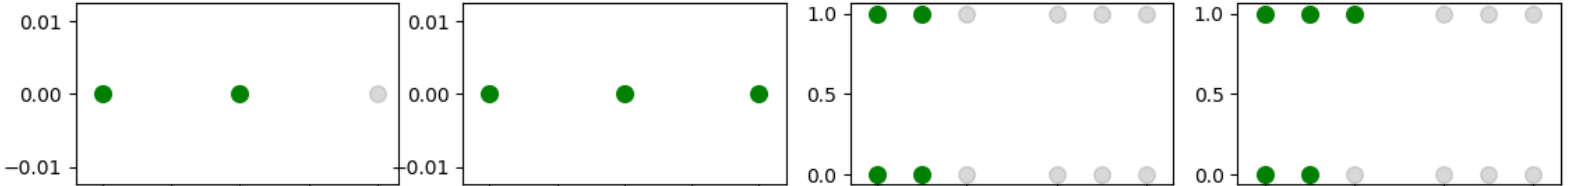
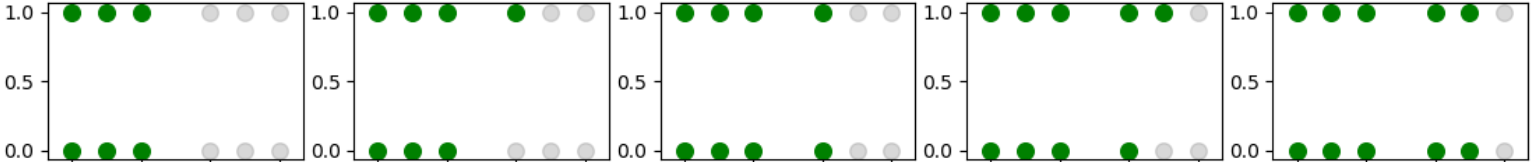
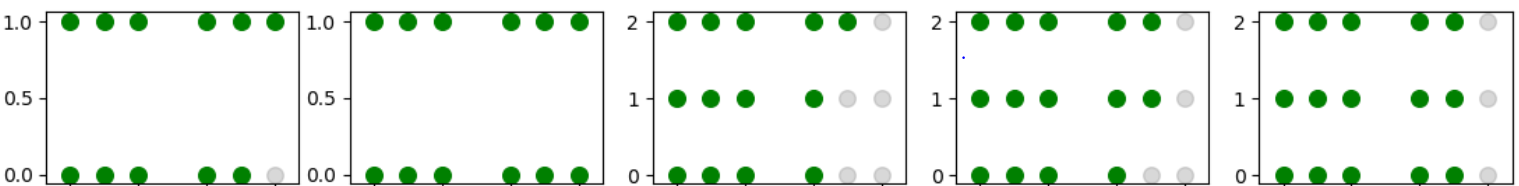

La fonction ci-dessous permet de donner les dimensions du rectangle optimal permettant de contenir tous les membres du groupe tout en maximisant le bonheur de ce dernier.

In [32]:
from math import ceil
 
def fact(n):
 
    if n == 0 or n == 1:
 
        return 1
 
    else:
 
        return n * fact(n-1)
 
def pack_size(group_size, height = True, classe = 'Y', WHCR = False):
    
    if classe == 'Y':
 
        L_values = []
        L_bound, S_bound = float('inf'), float('inf')
 
        for L in range(1,7):
 
            value = L + 2 * ceil(group_size / L)
 
            if value < L_bound:
 
                L_bound = value
                L_values = [L]
 
            elif value == L_bound:
 
                L_values.append(L)
 
        if len(L_values) == 1:
 
            L = L_values[0]
 
            return {'y': L, 'real_y': L + int(L > 3) + int(group_size == 3 and WHCR), 'x': ceil(group_size / L), 'air_bubbles': L*height - taille_groupe}
 
        else:
 
            if height:
 
                height_list = [ceil(group_size / L) for L in L_values]
                height = min(height_list)
                L = L_values[height_list.index(height)]
 
                return {'y': L, 'real_y': L + int(L > 3), 'x': height, 'air_bubbles': L*height - taille_groupe}
 
 
            else:    
 
                for L_value in L_values:
 
                    entropy = fact(L_value * ceil(group_size / L_value)) / (fact(L_value * ceil(group_size / L_value) - group_size) * fact(group_size))
 
                    if entropy < S_bound:
 
                        S_bound = entropy
                        L = L_value
 
            return {'y': L, 'real_y': L + int(L > 3), 'x': ceil(group_size / L), 'air_bubbles': L*ceil(group_size / L) - taille_groupe}        
        
    else:
        
        L_values = []
        L_bound, S_bound = float('inf'), float('inf')
 
        for L in range(1,5):
 
            value = L + 2 * ceil(group_size / L)
 
            if value < L_bound:
 
                L_bound = value
                L_values = [L]
 
            elif value == L_bound:
 
                L_values.append(L)
 
        if len(L_values) == 1:
 
            L = L_values[0]
 
            return {'y': L, 'real_y': 2*L - 1, 'x': ceil(group_size / L), 'air_bubbles': L*ceil(group_size / L) - taille_groupe}
 
        else:
 
            if height:
 
                height_list = [ceil(group_size / L) for L in L_values]
                height = min(height_list)
                L = L_values[height_list.index(height)]
 
                return {'y': L, 'real_y': 2*L - 1, 'x': height, 'air_bubbles': L*height - taille_groupe}
 
 
            else:    
 
                for L_value in L_values:
 
                    entropy = fact(L_value * ceil(group_size / L_value)) / (fact(L_value * ceil(group_size / L_value) - group_size) * fact(group_size))
 
                    if entropy < S_bound:
 
                        S_bound = entropy
                        L = L_value
 
            return {'y': L, 'real_y':2*L - 1, 'x': ceil(group_size / L), 'air_bubbles': L*ceil(group_size / L) - taille_groupe}

On remarque donc que les dispositions optimales sont relativement compactes d'où la notion de *compactage* que nous alons introduire à présent.

## Principe de compactage

<div style="text-align: justify,">
Dès lors, notre méthode consiste à faire en sorte que Gurobi place les passagers des groupes suivant le schémas de disposition optimale présenté ci-dessus. Initialement, nous avions pensé calculer le score de voisinage directement au sein de la simulation Gurobi en calculant ce dernier pour chaque passager à l'aide des variables $\pi_{xyp}$ et en le maximisant via la fonction objectif.
</div>

<div style="text-align: justify,">
Toutefois, le score étant intrinsèquement inclus dans la disposition optimale, pour notre implémentation finale, nous avons donc fait le choix de nous concentrer sur le compactage des groupes plutôt que le calcul du score de voisinage (qui de toute façon sera maximal si il est possible de placer les groupes de manière optimale).
</div>

## Méthode de la *mise sous vide*

<div style="text-align: justify,">
Afin d'imager la méthode d'optimisation que nous avons inventée, nous avons choisi de l'appeler la méthode de mise sous vide à cause de sa similarité relative au principe de mise sous vide d'aliments. En effet, cette dernière se déroule au travers des étapes suivantes :

* on sélectionne les aliments que l'on souhaite mettre sous vide ;
* on les dispose dans un sachet aussi petit que possible mais pouvant tous les contenir ;
* on enlève les bulles d'air restantes.
</div>

<div style="text-align: justify,">
    Notre méthode informatique de <i>mise sous vide</i> fonctionne donc suivant un principe similaire dont les étapes sont détaillées ci-dessous : 

* on s'intéresse uniquement aux groupes d'au moins 2 passagers ;
* en fonction de la taille du groupe, on détermine le plus petit rectangle (ou *sachet* optimal) pouvant contenir l'intégralité du groupe conformément aux dispositions optimales ;
* on encourage Gurobi à placer les membres du groupe dans le *sachet* en jouant sur les espacement dans le sens le la largeur (resp. longueur) de l'avion entre les passagers du groupe assis les plus à gauche (resp. les plus en haut) et ceux assis les plus à droite (resp. les plus en bas) ;
* si des sièges vides ou des passagers hors du groupe sont dans le sachet - ce qui est tout à fait possible *a priori* - (ce que l'on appelle des *bulles d'air*), on les *aspire* vers les coins du rectangle afin de maximiser la proximité des membres du groupe au sein du rectangle et donc leur bonheur. Pour cette dernière étape, il suffit de permuter la *bulle d'air* et un membre du groupe assis dans un coin en veillant à ce que les contraintes ne soient pas violées.
</div>

Nous allons à présent passer à l'implémentation informatique de cette méthode.

## Nouvelles variables de décision

<div style="text-align: justify,">
    Comme expliqué lors de la decription de la méthode de <i>mise sous vide</i>, nous avons besoin de connaître les espacements verticaux ou latéraux entre les membres du groupe situés aux <i>extrêmes</i> du rectangle les contenant tous. Pour cela, on introduit donc des variables $x_{min}^g$, $x_{max}^g$, $y_{min}^g$ et $y_{max}^g$ correspondant respectivement au plus petit numéro de rangée occupée par un membre du groupe $g$, au plus grand numéro de rangée occupée par un membre du groupe $g$, au plus petit numéro de colonne occupée par un membre du groupe $g$ et au grand petit numéro de colonne occupée par un membre du groupe $g$.
</div>

<div style="text-align: justify,">
Dans les faits, il n'est pas nécessaire d'imposer, par exemple, que $x_{min}^g$ est exactement égal au minimum des numéros de rangée pour l'ensemble des passagers de $g$, mais juste d'imposer qu'il est inférieur à tous les numéros de rangée pour l'ensemble des passagers du groupe car en optimisant, Gurobi fera en sorte que $x_{min}^g$ prenne exactement la valeur du minimum des numéros de rangée du groupe. Un raisonnement analogue existe évidemment pour les trois autres variables.
</div>

<div style="text-align: justify,">
On introduit également les variables d'écart $\Delta_x^g$ et $\Delta_y^g$ correspondant à la différence des valeurs extrêmes de $x$ et $y$ pour le groupe $g$, soit : $\Delta_x^g = x_{max}^g - x_{min}^g$ et $\Delta_y^g = y_{max}^g - y_{min}^g$.
</div>

In [33]:
X_MIN, X_MAX = {}, {}
DELTA_x = {}

for groupe in liste_groupes_sup1.keys():
    taille_groupe = listeGroupes[groupe].get_nombre_passagers()
    pack = pack_size(taille_groupe)
    if taille_groupe >= 2:
        X_MIN[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = 1, ub = avion['x_max'], name = "x_min_{},{},{}".format(x,y,groupe))
        X_MAX[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = 1, ub = avion['x_max'], name = "x_max_{},{},{}".format(x,y,groupe))
        DELTA_x[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = pack['x'] - 1, ub = 2*taille_groupe, name = "delta_{},{},{}".format(x,y,groupe))

In [34]:
X_MIN_constr, X_MAX_constr = {}, {}
DELTA_constr_x = {}

for groupe in liste_groupes_sup1.keys():
    if listeGroupes[groupe].get_nombre_passagers() >= 2:
        for passager in listeGroupes[groupe].list_passagers:
            p = passager.id_passager
            X_MIN_constr[p] = m.addConstr(X_MIN[groupe] <= quicksum(x*PI[x,y,p] for x,y in avion['seats']['real']))
            X_MAX_constr[p] = m.addConstr(X_MAX[groupe] >= quicksum(x*PI[x,y,p] for x,y in avion['seats']['real']))
            DELTA_constr_x[groupe] = m.addConstr(DELTA_x[groupe] == (X_MAX[groupe] - X_MIN[groupe]))

In [35]:
Y_MIN, Y_MAX = {},{}
DELTA_y = {}

for groupe in liste_groupes_sup1.keys():
    taille_groupe = listeGroupes[groupe].get_nombre_passagers()
    pack = pack_size(taille_groupe, classe = listeGroupes[groupe].classe, WHCR = (listeGroupes[groupe].composition['WHCR'] > 1))
    if taille_groupe >= 2:
        Y_MIN[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = 1, ub = avion['y_max'], name = "y_min_{},{},{}".format(x,y,groupe))
        Y_MAX[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = 1, ub = avion['y_max'], name = "y_max_{},{},{}".format(x,y,groupe))
        DELTA_y[groupe] = m.addVar(vtype = GRB.CONTINUOUS, lb = pack['real_y'] - 1, ub = 6, name = "delta_{},{},{}".format(x,y,groupe))

In [36]:
Y_MIN_constr, Y_MAX_constr = {}, {}
DELTA_constr_y = {}

for groupe in liste_groupes_sup1.keys():
    if listeGroupes[groupe].get_nombre_passagers() >= 2:
        for passager in listeGroupes[groupe].list_passagers:
            p = passager.id_passager
            Y_MIN_constr[p] = m.addConstr(Y_MIN[groupe] <= quicksum(y*PI[x,y,p] for x,y in avion['seats']['real']))
            Y_MAX_constr[p] = m.addConstr(Y_MAX[groupe] >= quicksum(y*PI[x,y,p] for x,y in avion['seats']['real']))
            DELTA_constr_y[groupe] = m.addConstr(DELTA_y[groupe] == (Y_MAX[groupe] - Y_MIN[groupe]))

## Fonction objectif

<div style="text-align: justify,">
    On souhaite donc faire en sorte que Gurobi dispose les membres du même groupe dans le <i>sachet</i> optimal pour nous permettre ensuite d'en retirer les <i>bulles d'air</i>. En notant $C_x^g$ et $C_y^g$ les écarts maximaux latéral et vertical entre les passagers du groupe $g$ quand ceux-ci sont placés dans le <i>sachet</i> optimal, il est immédiat que les différences $\Delta_x^g - C_x^g$ et $\Delta_y^g - C_y^g$ sont toutes les deux positives, et en particulier nulles quand les espacements maximaux entre membres du groupe coïncident avec ceux au sein du <i>sachet</i> optimal.
</div>

<div style="text-align: justify,">
Dans le cas optimal, on souhaite donc que toutes ces différences soient nulles, c'est-à-dire que tous les groupes soient placés dans leur sachet optimal, de telle sorte que nous n'ayons plus qu'à opérer des permutations intra-<i>sachet</i> pour maximiser le bonheur des groupes. A noter que les <i>sachets</i> sont tous indépendants les uns des autres donc la permutation de l'un n'affecte pas la disposition de l'autre.
</div>

Ainsi, notre fonction objectif s'écrit : $$\mbox{Minimize} \; \; \; \sum_{g \in \mathcal{G}_{2}^{+}} (\Delta_x^g - C_x^g) + (\Delta_y^g - C_y^g)$$

## Ajout des temps de correspondance

<div style="text-align: justify,">
Toutefois, le modèle n'est pas encore complet car les temps de correspondance des passagers ne sont pas pris en compte. Or, ces derniers jouent un rôle non négligeable dans la disposition des passagers dans l'avion. En effet, moins le temps de correspondance d'un passager est long, plus ce dernier doit être assis à l'avant de la cabine afin d'en sortir le plus vite possible et ainsi être en mesure d'avoir son avion suivant.
</div>

<div style="text-align: justify,">
Considérons un passager $p$ ayant un temps de correspondance $\tau_p$ et assis sur un siège de la rangée $x$. On introduit une <i>constante de sortie</i> $K_s$ qui matérialise en secondes le temps nécéssaire aux passagers pour sortir de leur rangée. Afin de sortir de la cabine, notre passager $p$ doit donc attendre $x-1$ fois un temps $K_s$ afin que les rangées devant la sienne ne se vident, puis nécessitera un temps $K_s$ afin de quitter la sienne. Au total, c'est d'un temps $K_sx$ dont il aura eu besoin pour sortir de la cabine.
</div>

<div style="text-align: justify,">
Ainsi, la formule $1-K_s\frac{x}{\tau_p}$ donne un nombre en 0 et 1 qui indique le pourcentage du temps de correspondance de $p$ dédié à son déplacment dans l'aéroport pour aller prendre son autre avion. On comprend donc que pour limiter le stress et accroître le bonheur des passagers, il convient de maximiser ce pourcentage autant que possible. Il conviendrait donc de maximiser la somme : <br><br> $$\sum_{p \in \mathcal{P}_\tau} 1-K_s\frac{x_p}{\tau_p}$$
</div> 

<div style="text-align: justify,">
Or, on sait d'après la partie précédente que dans la situation optimale, la somme $\sum_{g \in \mathcal{G}_{2}^{+}} (\Delta_x^g - C_x^g) + (\Delta_y^g - C_y^g)$ vaut exactement 0. On entrevoit donc la possibilité de fusionner nos deux sommes en une seule.
</div>

<div style="text-align: justify,">
On commence pour cela à multiplier par $-1$ cette somme afin que nous passions d'un problème de minimisation à un problème de maximisation. De plus, on souhaite compacter les groupes dans leur <i>sachet</i> optimal. Nous ne pouvons pas, pour cela, l'imposer sous forme de contrainte car ce ne serait pas assez permissif et pourrait conduire à l'infaisibilité du modèle. Toutefois, pour outrepasser cet écueil, il suffit de remplacer le poids $-1$ devant la somme $\sum_{g \in \mathcal{G}_{2}^{+}} (\Delta_x^g - C_x^g) + (\Delta_y^g - C_y^g)$ par un coefficient de pénalité $-\lambda \; (\lambda \geq 0)$ de notre choix - mais vraisemblablement plus grand en valeur absolue que 1 - de telle sorte que le modèle soit tellement pénalisé par un placement non optimal du groupe que Gurobi a plus qu'intérêt à la rendre égale à 0, c'est-à-dire compacter les groupes de manière optimale.
</div>

## Nouvelle écriture de la fonction objectif

<div style="text-align: justify,">
Compte tenu de toutes les remarques précédentes, on peut donc écrire la version finale de notre fonction objectif qui assure un placement optimal des groupes couplé à un placement à l'avant des passagers en correspondance.
</div>

$$\boxed{\mbox{Maximize} \; \; \; \sum_{p \in \mathcal{P}_\tau} \left ( 1-K_s\frac{x_p}{\tau_p} \right )- \lambda \sum_{g \in \mathcal{G}_{2}^{+}} \left [ (\Delta_x^g - C_x^g) + (\Delta_y^g - C_y^g) \right ]}$$

In [37]:
KS = 0.5 # Constante de sortie 
LAMBDA = 100 # Coefficient de pénalité

In [38]:
#m.setObjective(
#    quicksum(1 - KS * quicksum(x * PI[x,y,passager.id_passager] for x,y in avion['seats']['real'])/passager.transit_time for passager in listePassagers if passager.transit_time<float('inf'))
#    - LAMBDA * quicksum(DELTA_x[groupe] - pack_size(listeGroupes[groupe].get_nombre_passagers())['x'] + 1 for groupe in DELTA_x.keys())
#    - LAMBDA * quicksum(DELTA_y[groupe] - pack_size(listeGroupes[groupe].get_nombre_passagers(),classe = listeGroupes[groupe].classe,WHCR = (listeGroupes[groupe].composition['WHCR'] > 0))['real_y'] + 1 for groupe in DELTA_y.keys())
#    , GRB.MAXIMIZE
#)

In [39]:
m.setObjective(
    quicksum(quicksum(x * PI[x,y,passager.id_passager] for x,y in avion['seats']['real'])/passager.transit_time for passager in listePassagers if passager.transit_time<float('inf'))
    + LAMBDA * quicksum(DELTA_x[groupe] - pack_size(listeGroupes[groupe].get_nombre_passagers())['x'] + 1 for groupe in DELTA_x.keys())
    + LAMBDA * quicksum(DELTA_y[groupe] - pack_size(listeGroupes[groupe].get_nombre_passagers(),classe = listeGroupes[groupe].classe,WHCR = (listeGroupes[groupe].composition['WHCR'] > 0))['real_y'] + 1 for groupe in DELTA_y.keys())
    , GRB.MINIMIZE
)

# Optimisation

In [40]:
# -- Paramétrage --
m.params.outputflag = 1

# -- Mise à jour du modèle  --
m.update()

Parameter outputflag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


In [41]:
# Définition du callback
## -> interruption de l'optimization au delà d'un certain temps et en deçà d'un certain seuil

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > 600:
            model.terminate()
            

In [42]:
# -- Résolution --
start = timeit.default_timer()

m.optimize(softtime)

stop = timeit.default_timer()
duration = stop - start

now = datetime.now()
logging.basicConfig(filename=f'logs/{now.strftime("%d-%m-%Y_%H-%M-%S")}.log', filemode='w', format='%(message)s')
logging.warning(f"{date} - {AVION}: {duration} secondes")

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17763 rows, 46650 columns and 573022 nonzeros
Model fingerprint: 0x717090a1
Variable types: 138 continuous, 46512 integer (46512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 3551 rows and 20346 columns
Presolve time: 1.11s
Presolved: 14212 rows, 26304 columns, 379265 nonzeros
Variable types: 69 continuous, 26235 integer (26168 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.560784e+00, 6004 iterations, 1.38 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


# Affichage de la solution

Une fois la solution optimale du problème calculée par Gurobi, on commence par récupérer, pour chaque passager, les coordonnées du siège où il est assis à l'aide des variables de décision $\pi_{xyp}$.

In [43]:
placement = {}

for passager in listePassagers:
    for x,y in avion['seats']['real']:
        if PI[x,y,passager.id_passager].x == 1:
            placement[passager.id_passager] = (x,y)  
            
for groupe in listeGroupes.keys():
    print("Groupe #{} (temps de correspondance : {} min):".format(groupe,listeGroupes[groupe].transit_time))
    for passager in listeGroupes[groupe].list_passagers:
        if passager.id_passager in placement.keys():
            coord = placement[passager.id_passager]
            x,y = coord
            print("{} assis sur le siège {} = {}".format(passager.id_passager,coord,coordToSiege(x,y)))
    print("\n")    

Groupe #0 (temps de correspondance : inf min):
0 assis sur le siège (27, 3) = 26C
1 assis sur le siège (27, 6) = 26E
2 assis sur le siège (28, 6) = 27E
3 assis sur le siège (28, 5) = 27D
4 assis sur le siège (27, 2) = 26B
5 assis sur le siège (27, 7) = 26F
6 assis sur le siège (28, 7) = 27F
7 assis sur le siège (28, 1) = 27A
8 assis sur le siège (27, 5) = 26D
9 assis sur le siège (28, 2) = 27B
10 assis sur le siège (27, 1) = 26A


Groupe #1 (temps de correspondance : inf min):
11 assis sur le siège (7, 1) = 7A
12 assis sur le siège (7, 6) = 7E
13 assis sur le siège (7, 3) = 7C
14 assis sur le siège (7, 2) = 7B
15 assis sur le siège (7, 5) = 7D


Groupe #2 (temps de correspondance : inf min):
16 assis sur le siège (16, 2) = 16B
17 assis sur le siège (16, 3) = 16C
18 assis sur le siège (16, 1) = 16A


Groupe #3 (temps de correspondance : inf min):
19 assis sur le siège (26, 7) = 25F


Groupe #4 (temps de correspondance : inf min):
20 assis sur le siège (29, 7) = 28F


Groupe #5 (temps de

## Permutation des groupes

<div style="text-align: justify,">
    Conformément au paragraphe détaillant la méthode de <i>mise sous vide</i>, nous devons à présent nous assurer que la disposition des membres des groupes est optimale au sein de leurs <i>sachets</i> respectifs et opérer des permutations dans le cas contraire. Cette étape correpond au retrait des <i>bulles d'air</i> évoqué précédemment. Cette opération garantie d'améliorer la solution car on veille à ce que les permutations ne violent pas les contraintes (par exemple, si la <i>bulle d'air</i> est située sur une rangée au niveau d'une issue de secours, on s'assure de ne pas la permuter avec un enfant). De plus, si la <i>bulle d'air</i> est un passager voyageant seul extérieur au groupe, la permutation déplacera ce dernier sur un coin du rectangle (<i>sachet</i>) en faisant en sorte que sa position vis-à-vis de son temps de correspondance ne soit pas dégradée pour garantir l'optimalité de notre solution.
</div>

In [44]:
for groupe in listeGroupes:
    if listeGroupes[groupe].get_nombre_passagers() >= 4:
        x_min = min([placement[passager.id_passager][0] for passager in listeGroupes[groupe].list_passagers])
        x_max = max([placement[passager.id_passager][0] for passager in listeGroupes[groupe].list_passagers])
        y_min = min([placement[passager.id_passager][1] for passager in listeGroupes[groupe].list_passagers])
        y_max = max([placement[passager.id_passager][1] for passager in listeGroupes[groupe].list_passagers])
        
        cluster = [(i,j) for i in range(x_min,x_max+1) for j in range(y_min,y_max+1)]
        corners = [(x_min,y_min),(x_min,y_max),(x_max,y_min),(x_max,y_max)]
        
        if listeGroupes[groupe].get_nombre_passagers() != 13: # On gère à part le cas pathologique
            positions = {}
            void_coord = (0,0)
            for i,j in cluster:
                if (i,j) in avion['seats']['fictive'] or sum((passager.idx+1)*PI[i,j,passager.id_passager].x for passager in listePassagers) == groupe + 1:
                    positions[i,j] = 1
                elif sum((passager.idx+1)*PI[i,j,passager.id_passager].x for passager in listePassagers) == 0:
                    positions[i,j] = 0
                    void_coord = (i,j)
                else:
                    positions[i,j] = -1
                    void_coord = (i,j)
                                   
            if void_coord not in corners and void_coord != (0,0):
                i,j = void_coord
                
                if positions[i,j] == 0: # S'il y a un vide entre les passagers du groupe
                    if (i,j) in avion['seats']['exit']: # Si le trou est au niveau d'une issue de secours
                        if j <= 4:
                            # On échange avec le passager tout à gauche de la rangée
                            swap_passager = sum((passager.id_passager)*PI[i,y_min,passager.id_passager].x for passager in listePassagers)
                            placement[int(swap_passager)] = (i,j)

                        else:
                            # On échange avec le passager tout à droite de la rangée
                            swap_passager = sum((passager.id_passager)*PI[i,y_max,passager.id_passager].x for passager in listePassagers)
                            placement[int(swap_passager)] = (i,j)
                            
                    else: # Sinon dans le cas général
                        # On échange avec le passager tout en bas à gauche
                        swap_passager = sum((passager.id_passager)*PI[x_max,y_min,passager.id_passager].x for passager in listePassagers)
                        print(swap_passager)
                        placement[int(swap_passager)] = (i,j)
                        
                elif positions[i,j] == -1: # S'il y a un passager qui n'est pas membre du groupe dans le cluster  
                    if (i,j) in avion['seats']['exit'] or i == x_min: # Si le trou est au niveau d'une issue de secours ou que le passager a un temps de correspondance inférieur à celui du groupe
                        stranger = sum((passager.id_passager)*PI[i,j,passager.id_passager].x for passager in listePassagers)
                        swap_passager = sum((passager.id_passager)*PI[i,y_min,passager.id_passager].x for passager in listePassagers)
                        placement[int(swap_passager)] = (i,j)
                        placement[int(stranger)] = (i,y_min)
                    else: # Sinon dans le cas général
                        stranger = sum((passager.id_passager)*PI[i,j,passager.id_passager].x for passager in listePassagers)
                        swap_passager = sum((passager.id_passager)*PI[x_max,y_min,passager.id_passager].x for passager in listePassagers)
                        placement[int(swap_passager)] = (i,j)
                        placement[int(stranger)] = (x_max,y_min)
                        
                    
                    
            
            

71.0


In [45]:
# Création du dictionnaire des résultats statiques

PI_statique = {(x,y,p.id_passager): 0 for x in range(avion['x_max']+2) for y in range(avion['y_max']+2) for p in listePassagers}
for passager in listePassagers:
    p = passager.id_passager
    x,y = placement[p]
    PI_statique[x,y,p] = 1

### Export du résultat en CSV

In [46]:
def exporter_resultats(listeGroupes, placement):    
    list_id_groupe = []
    list_id_passager = []
    list_categorie = []
    list_classe = []
    list_transit_time = []
    list_poids = []
    list_x = []
    list_y = []
    list_siege = []
    list_classes = []
    
    for groupe in listeGroupes.keys():        
        for passager in listeGroupes[groupe].list_passagers:
            if passager.id_passager in placement.keys():
                x, y = placement[passager.id_passager]
                siege = coordToSiege(x, y)
                
                list_id_groupe.append(groupe)
                list_id_passager.append(passager.id_passager)
                list_categorie.append(passager.categorie)
                list_classe.append(passager.classe)
                list_transit_time.append(passager.transit_time)
                list_poids.append(passager.poids)
                list_x.append(x)
                list_y.append(y)
                list_siege.append(siege)
                list_classes.append(get_classe(x, y))
    
    df = pd.DataFrame({
        'ID Groupe': list_id_groupe,
        'ID Passager': list_id_passager,
        'Catégorie': list_categorie,
        'Classe': list_classe,
        'Transit Time': list_transit_time,
        'Poids': list_poids,
        'x': list_x,
        'y': list_y,
        'Siège': list_siege,
        'Classe': list_classes
    })
    
    filename = f'solution_{date}_{AVION}.csv'
    df.to_csv(os.path.join('output', filename), index=False)
    return df

In [47]:
df_ans = exporter_resultats(listeGroupes, placement)

In [48]:
df_ans.to_csv('solution_1.csv', index=False)

### Affichage de la figure de l'avion

#### Avec Plotly

In [49]:
marker_list = []

for passager in listePassagers:
    if passager.classe == "J":
        dot = "-dot"
    else:
        dot = ""
    if passager.categorie == "femmes":
        marker_list.append('circle'+dot)    
    elif passager.categorie == "hommes":
        marker_list.append('hexagon'+dot)
    elif passager.categorie == "enfants":
        marker_list.append('star'+dot)   
    elif passager.categorie == "WHCR":
        marker_list.append('star-square'+dot)  

In [50]:
import plotly.graph_objects as go
fig = px.scatter(
    df_ans,
    x='x',
    y='y',
    color='ID Groupe',
    hover_name='Siège',
    size='Poids',
    hover_data=df_ans.columns,
    title=f"Placement de passagers optimal pour l'{AVION} pour le {date[:date.index('N')]} Novembre",
    template="plotly_white",
    color_continuous_scale=px.colors.diverging.RdBu)

fig.update_traces(marker=dict(line=dict(width=2, color='black')),
                  marker_symbol=marker_list,
                  selector=dict(mode='markers'))

## Ajout du barycentre
fig.add_trace(
    go.Scatter(x=[sum(x*p.poids*PI[x,y,p.id_passager].x for x,y in avion['seats']['real'] for p in listePassagers) / masseTotalePassagers],
               y=[sum(y*p.poids*PI[x,y,p.id_passager].x for x,y in avion['seats']['real'] for p in listePassagers) / masseTotalePassagers],
               name="Barycentre",
               showlegend=True,
               marker_symbol=["star-triangle-up-dot"],
               mode="markers",
               marker=dict(size=20,
                           color="green",
                           line=dict(width=2, color='DarkSlateGrey'))))

# Positionnement de la légende
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))


## Ajout des barres colorées pour visualiser les emplacements spécifiques de l'avion
#Issues de Secours
fig.add_shape(x0=10.5,
              x1=12.5,
              y0=0.5,
              y1=0.6,
              fillcolor="red",
              line=dict(width=0),
              opacity=0.25)
fig.add_shape(x0=10.5,
              x1=12.5,
              y0=7.4,
              y1=7.5,
              fillcolor="red",
              line=dict(width=0),
              opacity=0.25)

#Classe Business
fig.add_shape(x0=0.5,
              x1=9.5,
              y0=0.5,
              y1=0.6,
              fillcolor="orange",
              line=dict(width=0),
              opacity=0.25)
fig.add_shape(x0=0.5,
              x1=9.5,
              y0=7.4,
              y1=7.5,
              fillcolor="orange",
              line=dict(width=0),
              opacity=0.25)

#Classe Economie
fig.add_shape(x0=9.5,
              x1=10.5,
              y0=0.5,
              y1=0.6,
              fillcolor="blue",
              line=dict(width=0),
              opacity=0.25)
fig.add_shape(x0=9.5,
              x1=10.5,
              y0=7.4,
              y1=7.5,
              fillcolor="blue",
              line=dict(width=0),
              opacity=0.25)
fig.add_shape(x0=12.5,
              x1=28.5,
              y0=0.5,
              y1=0.6,
              fillcolor="blue",
              line=dict(width=0),
              opacity=0.25)
fig.add_shape(x0=12.5,
              x1=28.5,
              y0=7.4,
              y1=7.5,
              fillcolor="blue",
              line=dict(width=0),
              opacity=0.25)


# Add images
fig.add_layout_image(avion['background']) 

fig.show()

# Etude dynamique

Pour le modèle dynamique, puisque nous conaissons à l'avance l'instance de vol, nous avons décidé de nous baser sur le modèle statique qui est l'une des possibilités optimales de placement, et de proposer à chaque groupe qui doit se placer une possibilité qui est obtenue en commutant des groupes du modèle statique. En effet, le but du modèle dynamique est de simuler la réalité lorsque les passagers choisissent eux-mêmes leur siège parmi une liste de sièges proposés.

Toutefois, le but est que les sièges proposés ne dégradent aucunement le *score* obtenu à l'aide du modèle dynamique car celui-ci est optimal. Nous le détaillerons plus précisément par la suite, mais compte tenu de notre paradigme, tant que l'intégrité des groupes n'est pas modifiée (c'est-à-dire que la taille des rectangles les englobant ne change pas) et que les passagers en correspondance restent à l'avant de l'avion, toute permutation de groupes de même taille et de même temps de correspondance est une autre solution optimale au problème (tant que les contraintes ne sont pas violées).

## Diversité des choix

Afin de proposer suffisamment de choix à un passager d'un groupe, nous avons donc pensé à proposer toutes les places des autres groupes de même taille (et même temps de transit), ce qui revient à choisir le placement du groupe. Nous nommons cette étape la permutation <i>inter-groupe</i>. Dans cette étape, on propose ainsi des sièges placés plus en avant ou plus en arrière du placement statique, apportant une première diversité. Ensuite, on permute les passagers à l'intérieur du groupe, pour que chaque passager du groupe puisse choisir où il s'asseye. Nous nous réfèrerons à cette étape par le terme permutation <i>intra-groupe</i>. Cela permet par exemple de proposer un siège à côté d'un hublot au lieu d'un siège à côté du couloir proposé par le modèle statique.
 
Cependant, cette première étape ne marche que pour des groupes qui ne sont pas seuls dans l'avion (i.e s'il existe d'autres groupes de même taille). Dans le cas contraire, il n'existerait que les choix des sièges dans le placement du groupe statique pour les passagers. Ainsi, nous avons intégré une étape préalable dite de permutation <i>inter-paquets</i> qui permet d'échanger un groupe avec une agrégation de groupes de plus petites tailles. Par voie de conséquence, on propose un nombre suffisant de choix pour chaque groupe, quelque soit l'occurence de sa taille dans l'instance de l'avion. L'arbre de choix ci-dessous résume les propos précédents.

![](assets/arbre.png)

## Faisabilité
Pour cela nous allons avoir besoin d'une fonction qui permet de vérifier rapidement qu'une configuration de placements est "faisable", c'est-à-dire qu'elle respecte les contraintes :
<ul>
    <li> de placement basiques (un passager par siège...)
    <li> de centrage de l'avion
    <li> d'accompagnement des enfants
    <li> d'interdiction de placer les enfants aux issues de secours
    <li> de placement des sièges roulants
</ul>
Cette fonction est rédigée ci-dessous.

In [51]:
def feasible(PI):
    
    '''
    Fonction qui vérifie que les contraintes précédentes sont vérifiées pour PI, dictionnaire du placement des passagers.
    
    '''
    
    # centrage de l'avion
    x_inf = sum(passager.poids*x*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) - avion['barycentre'][0]*masseTotalePassagers
    x_sup = -sum(passager.poids*x*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers)+avion['barycentre'][1]*masseTotalePassagers
    y_inf = sum(passager.poids*y*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) - avion['barycentre'][2]*masseTotalePassagers
    y_sup = -sum(passager.poids*y*PI[x,y,passager.id_passager] for x,y in avion['seats']['real'] for passager in listePassagers) + avion['barycentre'][3]*masseTotalePassagers
    
    if x_inf<0 or x_sup<0 or y_inf<0 or y_sup<0:
        return False
    
    # sièges fictifs
    delta_fictif = sum(PI[x,y,passager.id_passager] for x,y in avion['seats']['fictive'] for passager in listePassagers)
    
    if delta_fictif!=0:
        return False
    
    # au plus un passager par siège
    
    for x,y in avion['seats']['real']:
        if sum(PI[x,y,passager.id_passager] for passager in listePassagers) > 1:
            return False
    
    # exactement un siège par passager
    
    for passager in listePassagers:
        if sum(PI[x,y,passager.id_passager] for x,y in avion['seats']['real']) != 1:
            return False
        
    # pas d'enfant au niveau des issues de secours
    
    if sum(PI[x,y,passager.id_passager] for x,y in avion['seats']['exit'] for passager in listePassagers if passager.categorie == "enfants") != 0:
        return False
    
     # pas d'enfant isolé
        
    for groupe in liste_groupes_sup1.keys():
        nombre_enfants = listeGroupes[groupe].composition['enfants']
        nombre_adultes = listeGroupes[groupe].composition['femmes'] + listeGroupes[groupe].composition['hommes'] + listeGroupes[groupe].composition['WHCR']
        if nombre_enfants >= 1: # s'il y a au moins un enfant...
            for passager in listeGroupes[groupe].list_passagers:
                if passager.categorie == 'enfants':
                    e = passager.id_passager
                    for x, y in avion['seats']['real']:
                        voisinage = voisinage_lateral(x,y)
                        if nombre_enfants > 2*nombre_adultes:
                                if sum(PI[x, y+i, passager.id_passager] for i in voisinage for passager in listeGroupes[groupe].list_passagers if passager.id_passager != e) < PI[x, y, e]:
                                    return False
                        else:
                            if sum(PI[x, y+i, adulte.id_passager] for i in voisinage for adulte in listeGroupes[groupe].list_passagers if adulte.categorie != 'enfants') < PI[x, y, e]:
                                return False
                        
    # pas de passager Business en classe économique
    
    if sum(PI[x,y,passager.id_passager] for x,y in avion['seats']['eco'] for passager in listePassagers if passager.classe == "J") != 0 :
        return False
    
    # pas de passager économique en classe Business
    
    if sum(PI[x,y,passager.id_passager] for x,y in avion['seats']['business'] for passager in listePassagers if passager.classe == "Y") != 0 : 
        return False
    
    # contraintes sur les wheelchaires
    
    val_interdites_y = [1,3,5,7]

    if sum(PI[x,y,w.id_passager] for x,y in avion['seats']['real'] for w in listePassagers if w.categorie == 'WHCR' and y in val_interdites_y) != 0 :
        return False
    
    for x,y in avion['seats']['real']:
        if y in [2,6]:
            for passager in listePassagers:
                if passager.categorie == 'WHCR':
                    if sum((y == 2) * (PI[x,y+1,p.id_passager] + PI[x-1,y+1,p.id_passager]) + (y == 6) * (PI[x,y-1,p.id_passager] + PI[x-1,y-1,p.id_passager]) + PI[x-1,y,p.id_passager] for p in listePassagers if p.id_passager != passager.id_passager) > 3 * (1 - PI[x,y,passager.id_passager]):
                        return False
                
    # contraintes pour les x_max,x_min etc
    
    return True

## Affichage d'une configuration de l'avion

In [52]:
import plotly.graph_objects as go
def affichage_pi(PI): 
    '''
    Cette fonction sert à afficher une configuration donnée par le dictionnaire PI
    
    '''
    placement = {}

    for passager in listePassagers:
        for x,y in avion['seats']['real']:
            if PI[x,y,passager.id_passager] == 1:
                placement[passager.id_passager] = (x,y)  
                
    df=exporter_resultats(listeGroupes,placement)
    fig = px.scatter(
        df,
        x='x',
        y='y',
        color='ID Groupe',
        hover_name='Siège',
        size='Poids',
        hover_data=df.columns,
        title=f"Placement de passagers optimal pour l'{AVION} pour le {date[:date.index('N')]} Novembre",
        template="plotly_white",
        color_continuous_scale=px.colors.diverging.RdBu)

    fig.update_traces(marker=dict(line=dict(width=2, color='black')),
                      marker_symbol=marker_list,
                      selector=dict(mode='markers'))

    ## Ajout du barycentre
    fig.add_trace(
        go.Scatter(x=[sum(x*p.poids*PI[x,y,p.id_passager] for x,y in avion['seats']['real'] for p in listePassagers) / masseTotalePassagers],
                   y=[sum(y*p.poids*PI[x,y,p.id_passager] for x,y in avion['seats']['real'] for p in listePassagers) / masseTotalePassagers],
                   name="Barycentre",
                   showlegend=True,
                   marker_symbol=["star-triangle-up-dot"],
                   mode="markers",
                   marker=dict(size=20,
                               color="green",
                               line=dict(width=2, color='DarkSlateGrey'))))

    # Positionnement de la légende
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))


    ## Ajout des barres colorées pour visualiser les emplacements spécifiques de l'avion
    #Issues de Secours
    fig.add_shape(x0=10.5,
                  x1=12.5,
                  y0=0.5,
                  y1=0.6,
                  fillcolor="red",
                  line=dict(width=0),
                  opacity=0.25)
    fig.add_shape(x0=10.5,
                  x1=12.5,
                  y0=7.4,
                  y1=7.5,
                  fillcolor="red",
                  line=dict(width=0),
                  opacity=0.25)

    #Classe Business
    fig.add_shape(x0=0.5,
                  x1=9.5,
                  y0=0.5,
                  y1=0.6,
                  fillcolor="orange",
                  line=dict(width=0),
                  opacity=0.25)
    fig.add_shape(x0=0.5,
                  x1=9.5,
                  y0=7.4,
                  y1=7.5,
                  fillcolor="orange",
                  line=dict(width=0),
                  opacity=0.25)

    #Classe Economie
    fig.add_shape(x0=9.5,
                  x1=10.5,
                  y0=0.5,
                  y1=0.6,
                  fillcolor="blue",
                  line=dict(width=0),
                  opacity=0.25)
    fig.add_shape(x0=9.5,
                  x1=10.5,
                  y0=7.4,
                  y1=7.5,
                  fillcolor="blue",
                  line=dict(width=0),
                  opacity=0.25)
    fig.add_shape(x0=12.5,
                  x1=28.5,
                  y0=0.5,
                  y1=0.6,
                  fillcolor="blue",
                  line=dict(width=0),
                  opacity=0.25)
    fig.add_shape(x0=12.5,
                  x1=28.5,
                  y0=7.4,
                  y1=7.5,
                  fillcolor="blue",
                  line=dict(width=0),
                  opacity=0.25)


    # Add images
    fig.add_layout_image(avion['background']) 

    fig.show()
    return

## Commutations de groupes

Lorsque nous complétons l'avion en commençant par les premières réservations, nous le faisons au fur et à mesure du placement de l'avion. Cette variable sera un dictionnaire similaire aux variables ```PI``` présentées précédemment, que nous appellerons ```PI_dynamique```.
<br/>
<br/>
Pour parcourir toutes les possibilités de placement d'un passager, nous avons choisi de commencer par énumérer toutes les possibilités de placement de son groupe.
<br/>
1. On place le groupe en le permutant avec des groupes de taille inférieure dont l'agrégation donne un "bloc" de groupes de même forme (étape dite <i>inter-paquets</i>). Par exemple, un groupe de 5 peut être permuté avec un groupe de 3 et un groupe de 2 (si les passagers sont alignés). 
<br/>
<br/>
2. Ensuite, on permute le groupe avec tous les groupes de même taille et même temps de correspondance (étape dite <i>inter-groupes</i>).
<br/>

Il y a donc deux types de permutations à définir : les permutations dites élémentaires (<i>inter-groupes</i>) qui commutent un groupe avec tous ceux de même taille, et les permutations par agrégation (<i>inter-paquets</i>).
Il ne faut pas oublier ensuite de sélectionner toutes les possibilités faisables parmi celles-ci, à l'aide de la fonction <i>feasible</i>. Nous savons qu'il y en a toujours au moins une grâce au résultat du modèle statique.

<br/>
La diversité apportée par chacune de ces étapes est décrite dans l'explication de celles-ci ci-dessous.

### Commutations par agrégation ou <i>inter-paquets</i>
Lorsque nous voulons commuter des groupes nous pouvons le faire par agrégation : par exemple un groupe de 5 passagers alignés est équivalent à un groupe de 2 et d'un groupe de 3 passagers alignés. 
</br>

In [53]:
def intersect(l1,l2):
    aux = []
    for x in l1:
        if x in l2:
            aux.append(x)
    for x in l2:
        if x in l1:
            aux.append(x)  
    return list(set(aux))

La cellule en dessous permet de déterminer tous les paquets, c'est-à-dire tous les ensembles de lignes minimales comportant tous les passagers des groupes qui sont dans ces lignes. C'est tout l'objet notamment de la fonction <i>find_possible_paquets</i> qui renvoie un dictionnaire dont les clés sont les index des paquets et les valeurs associées les ensembles de lignes définissant le paquet.

In [54]:
def find_possible_paquets(PI_current,groupe_places):
    '''
    Trouve tout les paquets sur toutes les lignes. Un paquet est défini par le plus petit ensemble de lignes qui contient tous les groupes à partir de la première ligne
    
    '''
    groupe_par_paquet = {x:{'groupes':[],'transit_time':[]} for x in range(1,(avion['x_max']+1))}
    
    for x in range(1,(avion['x_max']+1)):
        for y in range(1,avion['y_max']+1):
            for passager in listePassagers:
                if PI_current[x,y,passager.id_passager] == 1:
                    groupe_par_paquet[x]['groupes'].append(passager.idx)
                    if passager.transit_time not in groupe_par_paquet[x]['transit_time']:
                        groupe_par_paquet[x]['transit_time'].append(passager.transit_time)
                        
    paquets = {}
    time_packs = {}
    compteur = 0
    rows = []
    
    x = 1

    while x <= avion['x_max']:

        rows = [x]
        met_times = groupe_par_paquet[x]['transit_time']

        groupes_set = set(groupe_par_paquet[x]['groupes'])
        stack = [(groupe,0) for groupe in groupes_set]
        group_stack = [tup[0] for tup in stack]

        max_gap = 0

        while len(stack) > 0:

            groupe,rank = stack[0]

            x_gap = pack_size(listeGroupes[groupe].get_nombre_passagers())['x'] - 1

            if x_gap + rank > max_gap:
                max_gap = x_gap + rank

            new_groupes = []
            new_groupes_stack = []

            for k in range(rank + 1,x_gap + 1):

                met_times += groupe_par_paquet[x+k]['transit_time']
                new_groupes += [(new_groupe,k) for new_groupe in groupe_par_paquet[x]['groupes'] if new_groupe not in group_stack]
                new_groupes_stack += [new_groupe for new_groupe in groupe_par_paquet[x]['groupes'] if new_groupe not in group_stack]

            stack += list(set(new_groupes))
            group_stack += list(set(new_groupes_stack))
            stack = stack[1:]

        if len(set(met_times)) != 1 or len(intersect(groupe_places,group_stack)) > 0:

            x += max_gap + 1

        else:

            x += max_gap + 1
            x0 = rows[0]
            rows += [x0+k for k in range(1,max_gap+1)]
            paquets[compteur] = {'rangees': rows, 'transit_time': met_times[0]}
            compteur += 1
            
    return paquets   

print(find_possible_paquets(PI_statique,[]))

{0: {'rangees': [1], 'transit_time': 60}, 1: {'rangees': [3, 4, 5], 'transit_time': 85}, 2: {'rangees': [6], 'transit_time': 85}, 3: {'rangees': [7], 'transit_time': inf}, 4: {'rangees': [8], 'transit_time': inf}, 5: {'rangees': [10], 'transit_time': inf}, 6: {'rangees': [11, 12], 'transit_time': inf}, 7: {'rangees': [13], 'transit_time': inf}, 8: {'rangees': [14], 'transit_time': inf}, 9: {'rangees': [15], 'transit_time': inf}, 10: {'rangees': [16], 'transit_time': inf}, 11: {'rangees': [17, 18, 19], 'transit_time': inf}, 12: {'rangees': [21], 'transit_time': inf}, 13: {'rangees': [22], 'transit_time': inf}, 14: {'rangees': [24], 'transit_time': inf}, 15: {'rangees': [25], 'transit_time': inf}, 16: {'rangees': [26], 'transit_time': inf}, 17: {'rangees': [27, 28], 'transit_time': inf}, 18: {'rangees': [29], 'transit_time': inf}, 19: {'rangees': [30], 'transit_time': inf}, 20: {'rangees': [31], 'transit_time': inf}, 21: {'rangees': [32], 'transit_time': inf}, 22: {'rangees': [33], 'tran

La fonction suivante recherche toutes les possibilités d'échange par commutations de lignes pleines, que nous appelerons paquets. Cette permutation apporte de la diversité dans la mesure où, si il existe un seul groupe d'une taille donnée, alors celui-ci ne pourra pas être échangé avec d'autres groupes de même taille mais pourra, avec cette fonction, être échangé avec une agrégation de groupes de tailles plus petites (les paquets définissant les deux devant être de même taille bien sûr)

In [55]:
def permutation_paquets(PI,groupe,groupe_places,limit_return):
    '''
    Fonction qui échange les paquets entre eux.
    Permutation dite 'inter paquet'
    '''
    
    compteur_sol = 0
    coord_groupe_bf = []
    possible_paquets =  find_possible_paquets(PI,groupe_places)

    liste_coord=[]
    for a,b in avion['seats']['real']:
        for p in listeGroupes[groupe].list_passagers:
            if PI[a,b,p.id_passager] == 1:
                liste_coord.append((a,b,p.id_passager))
    switch_feasible_paquets = [(PI,liste_coord)]
    #switch_feasible_paquets = []
    
    for i in range(len(list(possible_paquets.keys()))):
        
        tt_i = possible_paquets[i]['transit_time']
        len_i = len(possible_paquets[i]['rangees'])
        # vérification qu'on regarde bien le paquet associé au groupe
        bon_paquet = False
        for x in possible_paquets[i]['rangees']:
            for y in range(avion['y_max']+2):
                for p in listePassagers: 
                    if PI[x,y,p.id_passager] == 1 and p.idx==groupe:
                        bon_paquet = True         
        if bon_paquet:
            for j in range(len(list(possible_paquets.keys()))):
                PI_current = {(x,y,p): PI[x,y,p] for x,y,p in PI.keys()}
                if i!=j:
                    
                    tt_j  = possible_paquets[j]['transit_time']
                    len_j = len(possible_paquets[j]['rangees'])
                    
                    if tt_i==tt_j and len_i==len_j:
                        # échanger les paquets i et j, si c'est faisable bien sûr
                        
                        coord1 = []
                        coord2 = []
                        
                        for x in possible_paquets[i]['rangees']:
                            for y in range(avion['y_max']+2):
                                existe_passager1 = False
                                for p in listePassagers: # on peut chercher que dans les groupes sinon
                                    if PI[x,y,p.id_passager]==1:
                                        coord1.append((x,y,p))
                                        existe_passager1 = True
                                if not existe_passager1 :
                                    coord1.append((x,y,-1))
                                    
                        for x in possible_paquets[j]['rangees']:
                            for y in range(avion['y_max']+2):
                                existe_passager2 = False
                                for p in listePassagers:
                                    if PI[x,y,p.id_passager]==1:
                                        coord2.append((x,y,p))
                                        existe_passager2 = True
                                if not existe_passager2 :
                                    coord2.append((x,y,-1))

                        coord_groupe_new = []
                        
                        for k in range(len(coord1)):
                            
                            x1 = coord1[k][0]
                            y1 = coord1[k][1]
                            p1 = coord1[k][2]
                            
                            x2 = coord2[k][0]
                            y2 = coord2[k][1]
                            p2 = coord2[k][2]
                            
                            if type(p1)==type(-1) and type(p2)!=type(-1):
                                
                                PI_current[x1,y1,p2.id_passager]=1
                                
                                for p3 in listePassagers:
                                    
                                    PI_current[x2,y2,p3.id_passager]=0
                                    
                            elif type(p2)==type(-1) and type(p1)!=type(-1):
                                
                                PI_current[x2,y2,p1.id_passager]=1
                                
                                for p3 in listePassagers:
                                    
                                    PI_current[x1,y1,p3.id_passager]=0
                                    
                            elif type(p1)!=type(-1) and type(p2)!=type(-1):
                                
                                PI_current[x1,y1,p1.id_passager]=0
                                PI_current[x2,y2,p1.id_passager]=1
                                PI_current[x2,y2,p2.id_passager]=0
                                PI_current[x1,y1,p2.id_passager]=1

                            if type(p1)!=type(-1):
                                if p1.idx == groupe:
                                    coord_groupe_new.append((x2,y2,p1))
                                    coord_groupe_bf.append((x1,y1,p1))
                                    
                        # Maintenant on regarde si cette commutation est faisable
                        if feasible(PI_current) and compteur_sol<=limit_return:
                            switch_feasible_paquets.append((PI_current,coord_groupe_new))#ne pas faire attention aux p de coord2
                            compteur_sol+=1
    
    #switch_feasible_paquets.append((PI_current,coord_groupe_bf))
    return switch_feasible_paquets
 

### Commutations élémentaires ou <i>inter-groupes</i>
Les permutations élémentaires sont obtenues en commutant un groupe avec tous les autres groupes de même taille et de même temps de correspondance.
<br/>
La fonction suivante calcule toutes les possibilités faisables (satisfaisant aux contraintes) d'échange entre groupes de même taille, et de même temps de correspondance.

In [56]:
def find_possible_switches(groupe,PI,groupe_places,limit_return):
    '''
    Calcule toutes les configurations dans lesquelles le groupe 'groupe' peut être échangé avec un autre groupe
    Permutation dite 'inter-groupe'
    
    '''
    compteur_sol=0
    switch_feasible = []
    for groupe2 in listeGroupes.keys():
        if groupe2 not in groupe_places:
            if (listeGroupes[groupe].get_nombre_passagers() == listeGroupes[groupe2].get_nombre_passagers() and listeGroupes[groupe].transit_time==listeGroupes[groupe2].transit_time):
                PI_current = {}
                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        for passager in listePassagers:
                            PI_current[x,y,passager.id_passager]=PI[x,y,passager.id_passager]
                coord1 = []
                coord2 = []
                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        for p in listeGroupes[groupe].list_passagers:
                            if PI_current[x,y,p.id_passager]==1:
                                coord1.append((x,y,p))
                        for p in listeGroupes[groupe2].list_passagers:
                            if PI_current[x,y,p.id_passager]==1:
                                coord2.append((x,y,p))
                                
                for i in range(len(coord1)):
                    x1 = coord1[i][0]
                    y1 = coord1[i][1]
                    p1 = coord1[i][2]
                    x2 = coord2[i][0]
                    y2 = coord2[i][1]
                    p2 = coord2[i][2]
                    PI_current[x1,y1,p1.id_passager]=0
                    PI_current[x1,y1,p2.id_passager]=1
                    PI_current[x2,y2,p2.id_passager]=0
                    PI_current[x2,y2,p1.id_passager]=1
                # Maintenant on regarde si cette commutation est faisable
                if feasible(PI_current) and compteur_sol<=limit_return:
                    switch_feasible.append((PI_current,coord2))#ne pas faire attention aux p de coord2
                    compteur_sol+=1
                    
    return switch_feasible #contient la configuration de la commutation et la liste des nouvelles coordonnées du groupe

Pour limiter le nombre de possibilités de placement d'un groupe, nous avons décidé de sélectionner celles-ci selon un critère de diversité. En effet, il est plus intéressant pour un client d'avoir le choix entre une place couloir, une place au hublot, une place à l'avant et une près des toilettes plutôt qu'entre quatre places couloir...
<br/>
La fonction suivante sélectionne donc, pour une liste de configurations possibles de placement d'un passager (correspondant à la liste des possibilités de placement de ce passager), la sous-liste de possibilités avec le meilleur score de variété, de cardinal <i>max_sieges_possibles</i>.

In [57]:
import itertools

def diversite(liste_PI,passager,taille_max_sieges_possibles):
    '''
    détermine la diversité des sièges proposés au passager par la liste des PI possibles dans liste_PI
    renvoie la sous liste de taille taille_max_sieges_possibles parmi les possiblités liste_PI qui a la meilleure variété
    
    '''
    liste_sous_pi = list(itertools.combinations(liste_PI, taille_max_sieges_possibles))

    distances=[]
    
    
    for i in range(len(liste_sous_pi)):
        distance_inter_sièges = 0
        coord_sieges = []
        for j in range(taille_max_sieges_possibles):
            for x in range(avion['x_max']+2):
                for y in range(avion['y_max']+2):
                    if liste_PI[i][x,y,passager.id_passager]==1:
                        coord_sieges.append((x,y))
        for i in range(len(coord_sieges)-1):
            for j in range(i+1,len(coord_sieges)):
                distance_inter_sieges+=(coord_sieges[i][0]-coord_sieges[j][0])**2 +(coord_sieges[i][1]-coord_sieges[j][1])**2 
        distances.append(distance_inter_sieges)
    return liste_sous_pi[distances.index(max(distances))]
    

Nous pouvons encore limiter le nombre de possibilités puisque nous savons d'avance que si on échange un adulte avec un enfant, cela conduira probablement à une possibilité <i>unfeasible</i> puisqu'un enfant risque d'être séparé d'un adulte.
La fonction categorie match teste donc si l'on a le droit d'échanger deux passagers en fonction de leur catégorie.

In [58]:
def categorie_match(p1,p2):
    cat1 = p1.categorie
    cat2 = p2.categorie
    
    if cat1=="enfants" and cat2!="enfants":
        return False
    elif cat2=="enfants" and cat1!="enfants":
        return False
    else : 
        return True

## Commutations de passagers ou <i>intra-groupes</i>

Une fois que l'on a énuméré toutes les possibilités de placement d'un groupe, il reste encore à énumérer les répartitions possibles des passagers au sein de ce groupe.
<br/>
Une fois qu'un groupe a été placé (le placement est déterminé par le choix du premier passager), chaque passager du groupe peut réserver sa place à l'intérieur des places du groupe. La fonction suivante donne, pour un passager donné, toutes les possibilités "faisables" (selon la fonction <i>feasible</i> précédente) de placement de ce passager au sein du groupe. Autrement dit, ce sont toutes les permutations possibles respectant les contraintes entre le passager à placer et les places encore libres du groupe.

In [59]:
def find_possible_switches_passager(passager,PI,passager_places,limit_return):
    '''
    Fonction qui détermine toutes les permutations dans un groupe.
    Permutation dite 'intra groupe'
    
    '''
    groupe = passager.idx
    compteur_sol = 0
    switch_feasible = []
    for x in range(avion['x_max']+2):
        for y in range(avion['y_max']+2):
            if PI[x,y,passager.id_passager]==1:
                coord1=(x,y)
    for passager2 in listeGroupes[groupe].list_passagers :
        if categorie_match(passager,passager2):
            if passager2.id_passager not in passager_places.keys():
                PI_current = {}
                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        for passager3 in listePassagers:
                            PI_current[x,y,passager3.id_passager]=PI[x,y,passager3.id_passager]

                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        if PI_current[x,y,passager2.id_passager]==1:
                            coord2=(x,y)
                x1 = coord1[0]
                y1 = coord1[1]
                x2 = coord2[0]
                y2 = coord2[1]
                PI_current[x1,y1,passager.id_passager]=0
                PI_current[x1,y1,passager2.id_passager]=1
                PI_current[x2,y2,passager2.id_passager]=0
                PI_current[x2,y2,passager.id_passager]=1
                # Maintenant on regarde si cette commutation est faisable
                if feasible(PI_current) and compteur_sol<=limit_return:
                    switch_feasible.append((PI_current,coord2))
                    compteur_sol+=1

    return switch_feasible #contient la configuration de la commutation et la liste des nouvelles coordonnées du groupe

## Programme de placement dynamique

Nous avons maintenant tous les outils pour effectuer le placement dynamique. Ce processus est donc une série d'options proposées par notre programme et de réponses successives des clients à placer.
<br/>
<br/>
Le fonctionnement de notre placement dynamique est le suivant :
<ul>
    <li> On considère un client d'un groupe donné à placer
    <li> S'il s'agit du premier client du groupe à placer, nous proposons toutes les possibilités faisables de                  commutation de groupes (inter-paquets, inter-groupes et enfin intra-groupes), à l'aide des fonctions <i>find_possible_switches</i> et                <i>find_possible_paquets</i>. On limite le nombre de possibilités à chaque étape afin de diminuer la complexité du programme. Pour cela, on adapte la forme de l'arbre présenté au-dessus. Ainsi, si on a une grande diversité de tailles de groupes avec peu de groupes de même taille, on privilégiera plus de permutations <i>inter-paquets</i>, puisque les permutations <i>inter-groupes</i> seront limitées. Sinon, puisqu'on a beaucoup de groupes de même taille, on diminue le nombre de permutations <i>inter-paquets</i>, puisqu'on pourra faire suffisamment de permutations <i>inter-groupes</i>.
    <li> Puis toujours dans le cas du premier passager du groupe, pour chacune de ces possibilités, on propose au                passager toutes les places à l'intérieur du groupe qui sont faisables.
    <li> Le premier passager choisit parmi les options proposées.
    <li> Ensuite, pour chaque autre passager du groupe, on propose toutes les permutations faisables entre ce passager          et les places encore libres du groupe, et le passager effectue son choix. On effectue ici uniquement une permutation intra-groupe.
    <li> On répète ces opérations jusqu'au dernier groupe de l'instance.
</ul>

Pour savoir si l'on a déjà placé un passager du groupe, on utilise le booléen <i>existe_passager_place</i> que l'on incrémente à <i>True</i> après avoir placé le premier passager du groupe que l'on étudie.
On met à jour le dictionnaire PI_dynamique de placement des passagers au fur et à mesure.

Dans ce notebook, nous avons modélisé les choix de placement des passagers par une réponse aléatoire parmi les options que notre programme leur propose. Il suffit pour cela de laisser le paramètre <i>testing_input</i> à False afin que le programme choisisse aléatoirement le siège pour le passager. Si l'on souhaite décider du placement des passagers, il faut mettre True. Dans notre webApp, une interface graphique permettra de cliquer sur les sièges souhaités.

In [60]:
def build_df_frequences_size_groupes(date):
    df = pd.read_csv('./data/data_seating_' + date + '.csv')
    df['taille'] = df['Femmes'] + df['Hommes'] + df['Enfants'] + df['WCHR']
    return df.groupby('taille')['Femmes'].count().mean()
def build_table_all_instances(list_dates, build_df_frequences_size_groupes):
    df = pd.DataFrame(columns = ['date', 'value'])
    for date in list_dates:
        value = build_df_frequences_size_groupes(date)
        df_aux = pd.DataFrame({'date': [date], 'value': [value]})
        df = pd.concat([df, df_aux], axis = 0)
    return df
def get_params_return_utils(moyenne_tailles_groupes, threshold=10):
    """Permet d'avoir les paramètres de branching adaptés à chaque cas.
    """
    if moyenne_tailles_groupes <= 2:
        limit_return_intra = 3
        limit_return_inter_groupe = 2
        limit_return_inter_paquets = 5
    else:
        limit_return_intra = 3
        limit_return_inter_groupe = 5
        limit_return_inter_paquets = 1
    return limit_return_intra, limit_return_inter_groupe, limit_return_inter_paquets

moyenne_tailles_groupes = build_df_frequences_size_groupes(date)
limit_return_intra, limit_return_inter_groupe, limit_return_inter_paquets = get_params_return_utils(moyenne_tailles_groupes)

In [61]:
from time import time

#Initialisation du placement
testing_input=False # False si on place aléatoirement les passagers, True si on veut les placer avec un input python.
limit_options = 10

PI_dynamique = {}
for x in range(avion['x_max']+2):
    for y in range(avion['y_max']+2):
        for passager in listePassagers:
            PI_dynamique[x,y,passager.id_passager]=PI_statique[x,y,passager.id_passager]
            
            
            
placement_dynamique = {}                 
            
groupe_places = []
passager_places = {}

S = 0

start = time()

moyenne_tailles_groupes = build_df_frequences_size_groupes(date)
limit_return_intra, limit_return_inter_groupe, limit_return_inter_paquets = get_params_return_utils(moyenne_tailles_groupes)
#limit_return_intra = 3 # nombre de permutations qu'on autorise 'intra groupe'
#limit_return_inter_groupe = 3 # nombre de permutations qu'on autorise 'inter groupe'
#limit_return_inter_paquets = 3 # nombre de permutations qu'on autorise 'inter paquets'

# Placement des groupes les uns après les autres, passagers par passagers

for groupe in list(listeGroupes.keys()): # Pour chaque groupe dans l'ordre de réservation
    
    print("Avancement : {} %".format((groupe/len(list(listeGroupes.keys()))*100)))
    
    
    
    existe_passager_place = False
    for passager in listeGroupes[groupe].list_passagers:
        if existe_passager_place:

            # intra groupe
            switch_feasible = find_possible_switches_passager(passager,PI_dynamique,passager_places,limit_return_intra)

            ALL_SEATS = {}
            for i in range(min(limit_options,len(switch_feasible))):
                x,y = switch_feasible[i][1]
                ALL_SEATS[(x,y)] = switch_feasible[i][0]

               
            
            #print(ALL_SEATS.keys())
            n = len(ALL_SEATS.keys())
            S += n
            print(f"Le groupe {groupe} a {n} choix")
            
            if testing_input:
                print(ALL_SEATS.keys())
                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        plt.scatter(x,y,color='grey',alpha=0.3,s=70)
                for i,j in ALL_SEATS.keys():
                    plt.scatter(i,j,color='red',s=70)
                for p in passager_places.keys():
                    i,j = passager_places[p]
                    plt.scatter(i,j,color='blue',s=70) 
                plt.show()  
                x = int(input('Rangée : '))
                y = int(input('Colonne : '))
            
            else:
                x,y = list(ALL_SEATS.keys())[randint(0,n-1)]
                
            PI_dynamique = ALL_SEATS[(x,y)] 
            passager_places[passager.id_passager] = (x,y)

        else :
            
            # toutes les permutations possibles
            ALL_SEATS = {}
            
            # permutations inter-paquets
            switch_feasible_paquets = permutation_paquets(PI_dynamique,groupe,groupe_places,limit_return_inter_paquets)
            #print('paquets',switch_feasible_paquets)
            for l in range(len(switch_feasible_paquets)):
                
                # permutation inter-groupes
                switch_feasible_inter_groupe = find_possible_switches(groupe,switch_feasible_paquets[l][0],groupe_places,limit_return_inter_groupe)

                
                for j in range(len(switch_feasible_inter_groupe)):
                    # permutation intra-groupes
                    switch_feasible = find_possible_switches_passager(passager,switch_feasible_inter_groupe[j][0],passager_places,limit_return_intra)


                    for i in range(min(limit_options,len(switch_feasible))):
                        x,y = switch_feasible[i][1]
                        ALL_SEATS[(x,y)] = switch_feasible[i][0]


            #print(ALL_SEATS.keys())
            n = len(ALL_SEATS.keys())
            S += n
            print(f"Le groupe {groupe} a {n} choix")

            if testing_input:
                n = len(ALL_SEATS.keys())
                for x in range(avion['x_max']+2):
                    for y in range(avion['y_max']+2):
                        plt.scatter(x,y,color='grey',alpha=0.3,s=70)
                for i,j in ALL_SEATS.keys():
                    plt.scatter(i,j,color='red',s=70)
                plt.show()  
                x = int(input('Rangée : '))
                y = int(input('Colonne : '))
            else:
                x,y = list(ALL_SEATS.keys())[randint(0,n-1)]
            PI_dynamique = ALL_SEATS[(x,y)]

            groupe_places.append(groupe)
            passager_places[passager.id_passager] = (x,y)
            existe_passager_place  = True
           
        
stop = time()
print('time =',stop-start)
print(S/len(list(listeGroupes.keys())))              

Avancement : 0.0 %
Le groupe 0 a 1 choix
Le groupe 0 a 10 choix
Le groupe 0 a 9 choix
Le groupe 0 a 8 choix
Le groupe 0 a 7 choix
Le groupe 0 a 6 choix
Le groupe 0 a 5 choix
Le groupe 0 a 4 choix
Le groupe 0 a 3 choix
Le groupe 0 a 2 choix
Le groupe 0 a 1 choix
Avancement : 1.7857142857142856 %
Le groupe 1 a 15 choix
Le groupe 1 a 4 choix
Le groupe 1 a 3 choix
Le groupe 1 a 2 choix
Le groupe 1 a 1 choix
Avancement : 3.571428571428571 %
Le groupe 2 a 6 choix
Le groupe 2 a 2 choix
Le groupe 2 a 1 choix
Avancement : 5.357142857142857 %
Le groupe 3 a 28 choix
Avancement : 7.142857142857142 %
Le groupe 4 a 21 choix
Avancement : 8.928571428571429 %
Le groupe 5 a 1 choix
Le groupe 5 a 2 choix
Le groupe 5 a 1 choix
Avancement : 10.714285714285714 %
Le groupe 6 a 1 choix
Le groupe 6 a 2 choix
Le groupe 6 a 1 choix
Avancement : 12.5 %
Le groupe 7 a 10 choix
Le groupe 7 a 9 choix
Le groupe 7 a 8 choix
Le groupe 7 a 7 choix
Le groupe 7 a 6 choix
Le groupe 7 a 5 choix
Le groupe 7 a 4 choix
Le group

In [62]:
affichage_pi(PI_dynamique)

## Visualisation sur la WebApp

Afin de créer une expérience intéractive du placement dynamique des passagers, nous avons développé une WebApp sous Dash liée à ce projet grâce à laquelle vous pouvez, pour chaque date, placer à votre guise les passagers de l'instance. Pour cela, lancez le fichier ```app_dynamic_selection.py``` contenu dans le projet (il faut au préalable avoir installé Dash sur votre ordinateur via la commande ```pip install dash```). Choisissez une date puis, pour chaque passager, l'ensemble des sièges qui lui sont offert appraîtront en vert. Cliquez sur l'un deux puis sur le bouton *VALIDER* afin de le placer définitivement et de continuer avec le passager suivant.

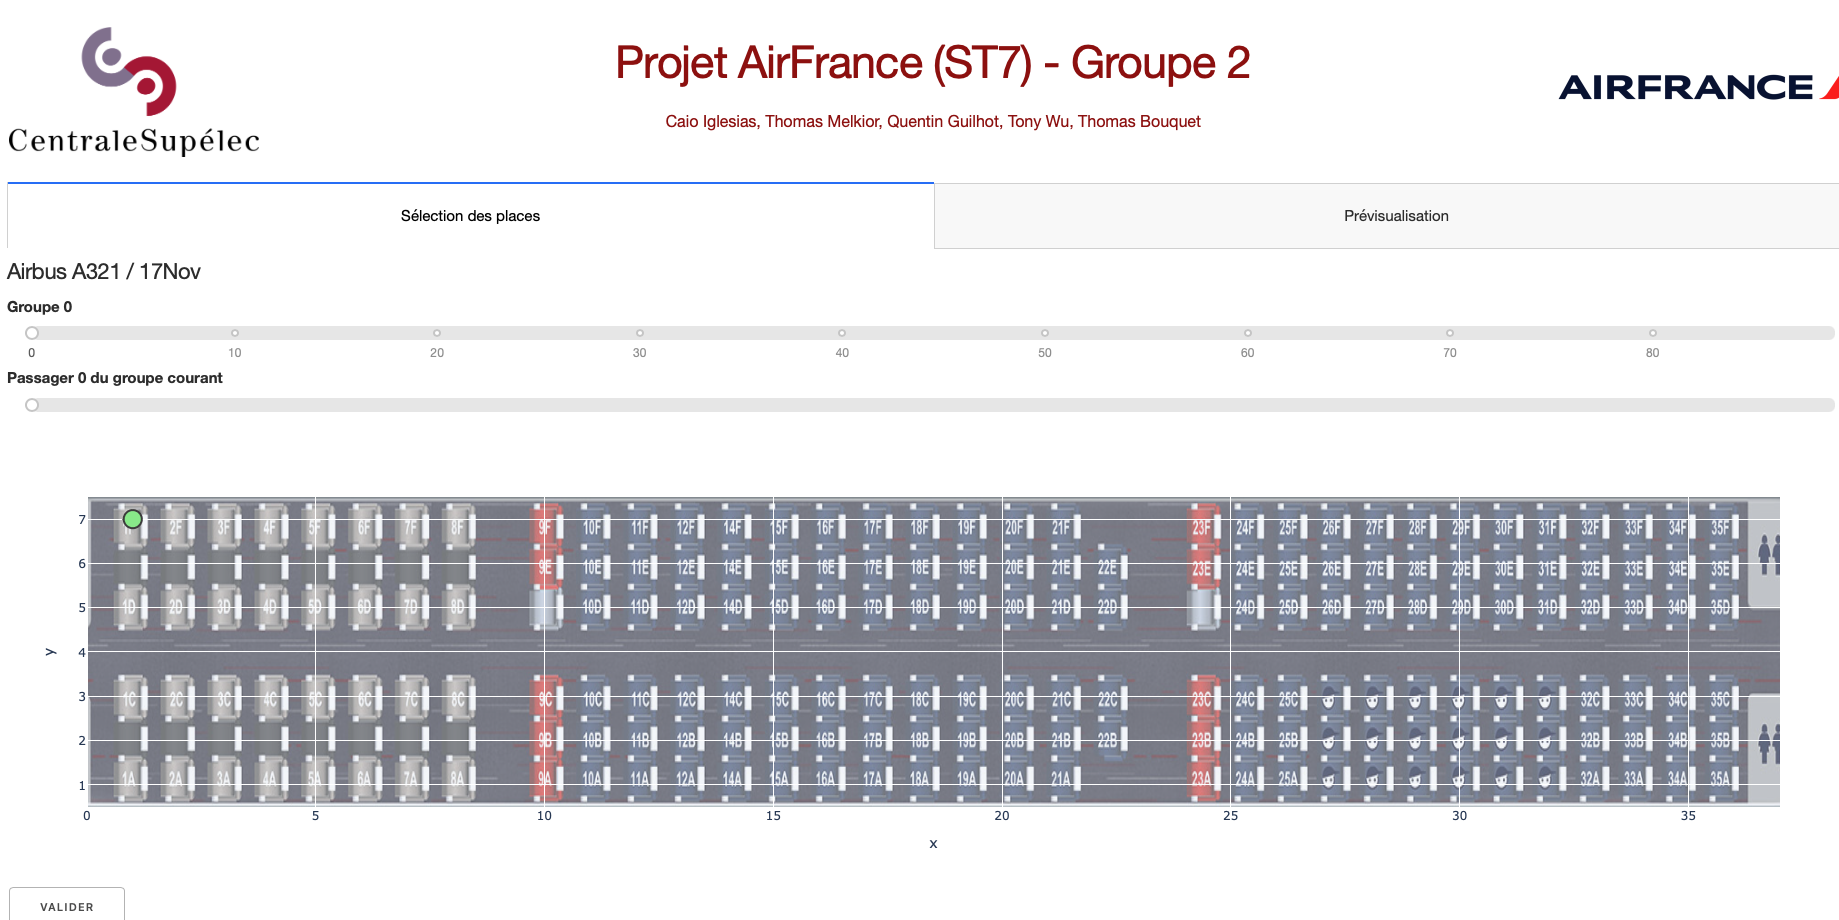

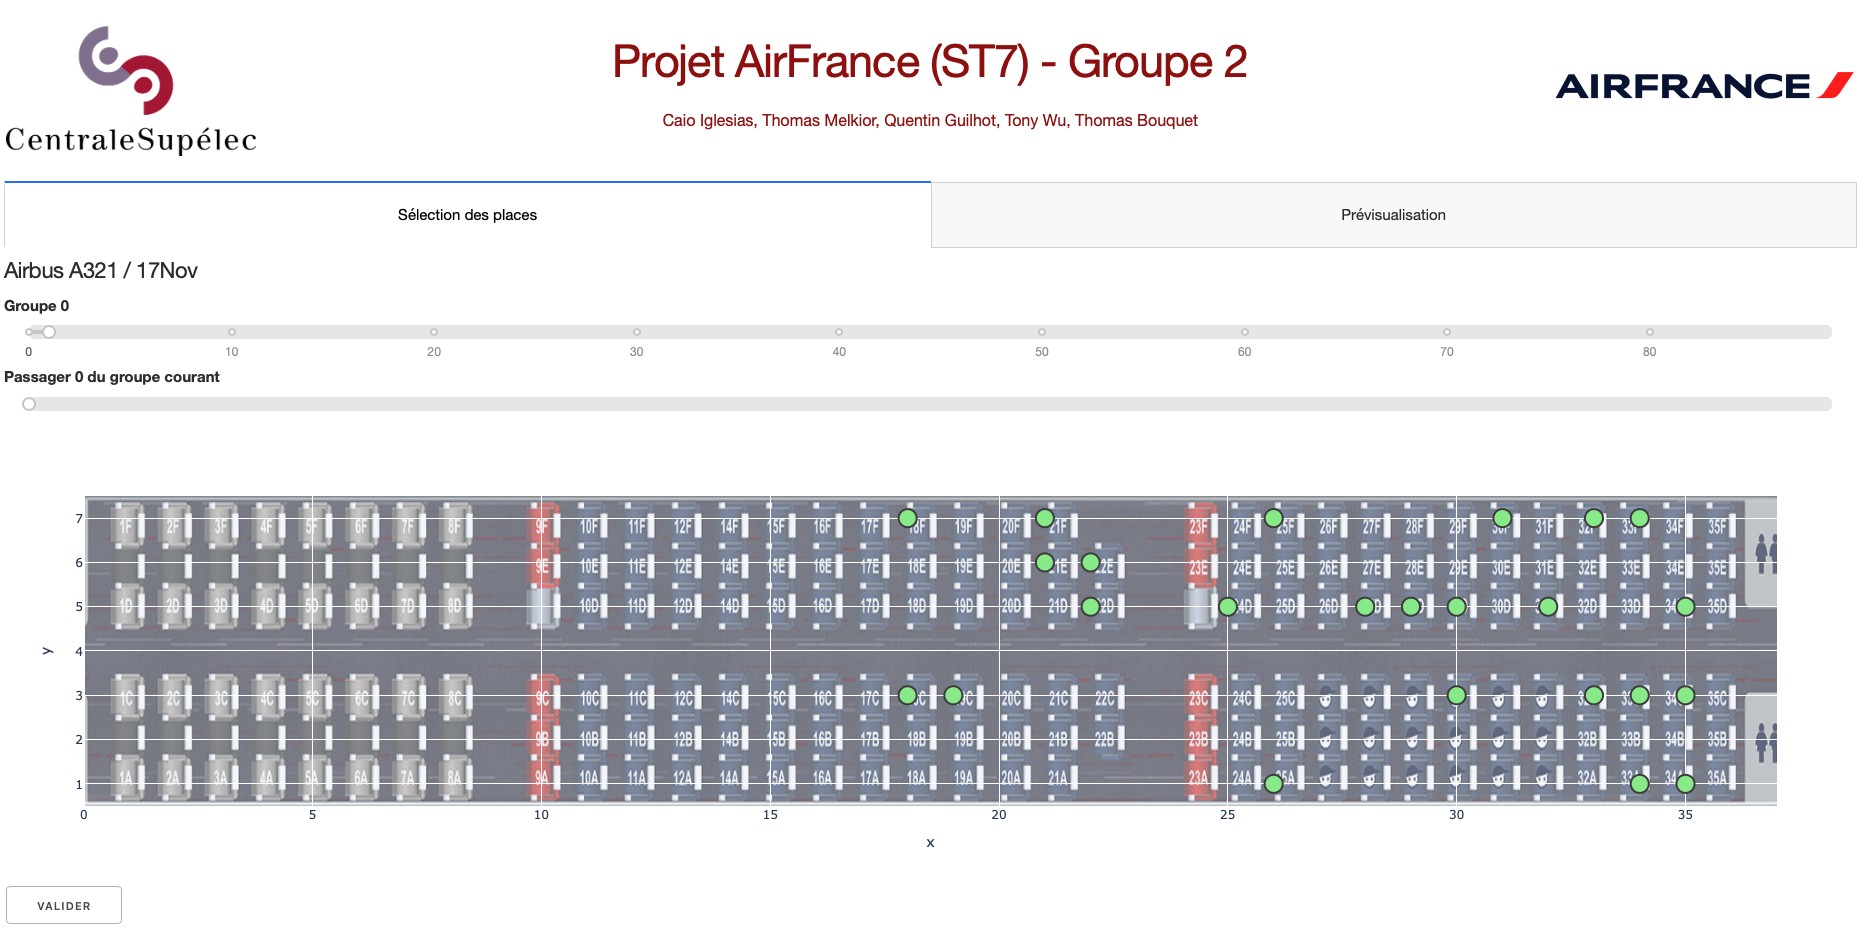